# Advanced Data Projekt

## Inhaltsverzeichnis
1. [Vorbereitungen](#1-vorbereitungen)
    1. [Einrichtung venv und Installation der Abhängigkeiten](#11-einrichtung-venv-und-installation-der-abhängigkeiten)
    2. [Konfiguration und Starten des Spark Clusters](#12-konfiguration-und-starten-des-spark-cluster)
    3. [Dateipfade festlegen und allgemeine Variablen](#13-dateipfade-festlegen-und-allgemeine-variable)
    4. [Anlage des Spark Context](#14-anlage-des-spark-session)
    5. [Anzeige der Spark WebUI](#15-anzeige-der-spark-webui)
2. [Datenauswertung](#2-datenauswertungen)
    1. [Auswertung - Weltweite Flughäfen](#21-auswertung---weltweite-flughäfen)
    2. [Auswertung - Registrierte Flugobjekte](#22-auswertung---registrierte-flugobjekte)
    3. [Auswertung - Bewegungsdaten von Flugobjekten](#23-auswertung---bewegungsdaten-von-flugobjekten)
    4. [Auswertung - Kombination Flugobjekte und Bewegungsdaten](#24-auswertung---kombination-flugobjekte-und-bewegungsdaten)
    5. [Auswertung - Flugobjekte und Verknüpfung mit Flughäfen](#25-auswertung---flugobjekte-und-verknüpfung-mit-flughäfen)
    6. [Auswertung - Kombination Flugobjekte und Bewegungsdaten](#2)
    7. [Auswertung - Visualisierung ausgewählter Bewegungsdaten](#27-auswertung---visualisierung-ausgewählter-bewegungsdaten)
    8. [Auswertung - Visualisierung zufällige Bewegungsdaten](#28-auswertung---visualisierung-zufälliger-bewegungsdaten)
    9. [Auswertung - Heatmap der  Bewegungsdaten](#29-auswertung---heatmap-der-bewegungsdaten)
3. [Analyse der Auswertungen](#3-analyse-der-auswertungen)
    1. [Definition der Analyse Funktionen](#31-definition-der-analyse-funktionen)
    2. [Analyse - Weltweite Flughäfen](#32-analyse---auswertung---weltweite-flughäfen)
    3. [Analyse - Registrierte Flugobjekte](#33-auswertung---registrierte-flugobjekte)
    4. [Analyse - Bewegungsdaten von Flugobjekten](#34-analyse--bewegungsdaten-von-flugobjekten)
    5. [Analyse - Bewegungsdaten von Flugobjekten](#35-analyse---kombination-flugobjekte-und-bewegungsdaten)
    6. [Analyse - Heatmap der Bewegungsdaten](#36-analyse---heatmap-der-bewegungsdaten)
4. [Experimente](#4-weitere-experimente)


## 1 Vorbereitungen
### 1.1 Einrichtung venv und Installation der Abhängigkeiten

1. Installiere Python 3.13.1:
- macOS: brew install python@3.13

- Windows: pip install python 3.13.1 (falls pip die Version unterstützt)

2. Erstelle das virtuelle Umfeld mit Python 3.13.1:
- macOS: python3.13 -m venv venv
- Windows: python -m venv venv

3. Aktiviere das virtuelle Umfeld:
- macOS: source venv/bin/activate
- Windows: .\venv\Scripts\activate

4. Installiere die Abhängigkeiten im venv
- Abhängigkeiten liegen im GitHub vor
- Datei in das angelegte venv verschieben
- requirements.txt:pip install -r requirements.txt

### 1.2 Konfiguration und Starten des Spark Cluster

Konfigurieren des Clusters
1. Pfad standardmäßig unter /usr/local/spark-<version>/conf
    - Pfadangabe kann unter Windows variieren
    - Vermutlich C:\Program Files\spark\spark-<version>\conf
2. Folgende Pfadangabe entsprechend definieren:
    - SPARK_HOME
3. Folgende Parameter wie gewünscht definieren:
    - SPARK_WORKER_INSTANCES
    - SPARK_WORKER_CORES
    - SPARK_WORKER_MEMORY
4. Java muss installiert und folgende Umgebungsvariable unter Windows gesetzt sein
    - JAVA_HOME

In [1]:
import platform

SPARK_HOME = "C:/Users/janko/Documents/spark-3.5.4-bin-hadoop3" if platform.system() == 'Windows' else "/usr/local/spark-3.5.3-bin-hadoop3/"

# Nutzerdefinierte Einstellungen
WORKER_INSTANCES = 2  # Anzahl der Worker
WORKER_CORES = 2      # Anzahl der CPU-Kerne pro Worker
WORKER_MEMORY = "2g"  # Arbeitsspeicher pro Worker


In [2]:
import os
import subprocess
import time
import psutil
import platform


def find_spark_workers():
    """Findet alle laufenden Spark Worker Prozesse."""
    worker_pids = []
    for proc in psutil.process_iter(['pid', 'cmdline']):
        try:
            if 'org.apache.spark.deploy.worker.Worker' in str(proc.info['cmdline']):
                worker_pids.append(proc.pid)
        except Exception:
            continue
    return worker_pids


def kill_spark_processes():
    """Beendet alle laufenden Spark Master und Worker Prozesse."""
    print("Beende vorhandene Spark-Prozesse...")
    for proc in psutil.process_iter(['pid', 'cmdline']):
        try:
            cmdline = str(proc.info['cmdline'])
            if 'org.apache.spark.deploy.master.Master' in cmdline or 'org.apache.spark.deploy.worker.Worker' in cmdline:
                process = psutil.Process(proc.pid)
                process.terminate()
                time.sleep(1)
                if process.is_running():
                    process.kill()
        except Exception:
            continue


def get_classpath_windows(spark_home):
    """Erstellt den Classpath für Windows, indem alle JAR-Dateien im Spark-Ordner hinzugefügt werden."""
    jars_dir = os.path.join(spark_home, 'jars')
    if not os.path.exists(jars_dir):
        raise FileNotFoundError(f"Jars-Verzeichnis wurde nicht gefunden: {jars_dir}")

    jars = [os.path.join(jars_dir, jar) for jar in os.listdir(jars_dir) if jar.endswith('.jar')]
    return os.pathsep.join(jars)


def start_spark_process_windows(main_class, args):
    """Startet einen Spark-Prozess unter Windows."""
    java_home = os.environ.get('JAVA_HOME')
    if not java_home:
        raise ValueError("JAVA_HOME muss gesetzt sein!")

    java_exe = os.path.join(java_home, 'bin', 'java.exe')
    if not os.path.exists(java_exe):
        raise FileNotFoundError(f"java.exe wurde nicht unter {java_exe} gefunden.")

    classpath = get_classpath_windows(SPARK_HOME)
    cmd = [java_exe, '-cp', classpath, main_class] + args
    print(f"Starte {main_class.split('.')[-1]} auf Windows...")
    return subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


def start_spark_process_unix(script_path, args):
    """Startet einen Spark-Prozess mit einer .sh-Datei auf macOS/Linux."""
    cmd = [script_path] + args
    print(f"Starte Prozess mit Skript: {script_path}")
    return subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)


def setup_spark_cluster(worker_count, worker_cores, worker_memory):
    """Startet einen Spark Cluster mit Master und Workers."""
    print("\n=== Starte Spark Cluster Setup ===")
    print(f"Worker Count: {worker_count}")
    print(f"Cores pro Worker: {worker_cores}")
    print(f"Memory pro Worker: {worker_memory}")

    # Alte Prozesse beenden
    kill_spark_processes()
    time.sleep(2)

    is_windows = platform.system() == 'Windows'

    # Master starten
    if is_windows:
        master_process = start_spark_process_windows(
            'org.apache.spark.deploy.master.Master',
            ['--host', '127.0.0.1', '--port', '7077']
        )
    else:
        master_script = os.path.join(SPARK_HOME, 'sbin', 'start-master.sh')
        master_process = start_spark_process_unix(master_script, [])
    
    print("Warte auf Master-Start...")
    time.sleep(5)

    # Workers starten
    worker_processes = []
    print(f"Starte {worker_count} Worker...")
    for i in range(worker_count):
        if is_windows:
            worker = start_spark_process_windows(
                'org.apache.spark.deploy.worker.Worker',
                [
                    'spark://127.0.0.1:7077',
                    '--cores', str(worker_cores),
                    '--memory', worker_memory
                ]
            )
        else:
            worker_script = os.path.join(SPARK_HOME, 'sbin', 'start-worker.sh')
            worker = start_spark_process_unix(worker_script, ['spark://127.0.0.1:7077'])
        
        worker_processes.append(worker)
        time.sleep(2)

    # Status prüfen
    time.sleep(3)
    worker_pids = find_spark_workers()
    print(f"Aktive Worker PIDs: {worker_pids}")
    print("Cluster-Setup abgeschlossen!")
    
    return worker_pids


def cleanup_spark_cluster():
    """Beendet den Spark Cluster."""
    print("\n=== Beende Spark Cluster ===")
    kill_spark_processes()
    print("Alle Spark-Prozesse beendet.")


# Cluster starten
worker_pids = setup_spark_cluster(
    worker_count=WORKER_INSTANCES,
    worker_cores=WORKER_CORES,
    worker_memory=WORKER_MEMORY
)


=== Starte Spark Cluster Setup ===
Worker Count: 2
Cores pro Worker: 2
Memory pro Worker: 2g
Beende vorhandene Spark-Prozesse...
Starte Prozess mit Skript: /usr/local/spark-3.5.3-bin-hadoop3/sbin/start-master.sh
Warte auf Master-Start...
Starte 2 Worker...
Starte Prozess mit Skript: /usr/local/spark-3.5.3-bin-hadoop3/sbin/start-worker.sh
Starte Prozess mit Skript: /usr/local/spark-3.5.3-bin-hadoop3/sbin/start-worker.sh
Aktive Worker PIDs: [17151, 17191]
Cluster-Setup abgeschlossen!


### 1.3 Dateipfade festlegen und allgemeine Variable

- `airport_data_path`: Pfad zur CSV-Datei mit Flughafendaten (`airports.csv`).
- `aircraft_data_path`: Pfad zur CSV-Datei mit vollständigen Flugzeugdaten (`aircraft-database-complete-2024-10.csv`).
- `flight_data_path`: Pfad zur CSV-Datei mit vorverarbeiteten Flugbewegungsdaten (`processed_data_reduced.csv`).

In [3]:
airport_data_path = "data/airports.csv"
aircraft_data_path = 'data/aircraft-database-complete-2024-10.csv'
flight_data_path = 'data/processed_data_reduced.csv'
master_url = "http://localhost:4040"  
dquote='\"'

### 1.4 Anlage des Spark Session
Spark-Context erstellen und notwendige Frameworks importieren

In [4]:
import pyspark
from pyspark.sql import SparkSession

# Funktion zur Erstellung einer Spark-Session mit Konfiguration
def create_spark_session(app_name="AdvancedDataProject"):
    # Spark-Konfigurationen festlegen
    conf = pyspark.SparkConf()
    conf.set("spark.driver.bindAddress", "127.0.0.1")   # Bindet den Driver an die lokale Adresse
    conf.set("spark.driver.host", "127.0.0.1")          # Setzt die Host-Adresse für den Driver
    conf.setMaster("spark://127.0.0.1:7077")            # Verbindet sich mit dem Standalone-Master
    conf.setAppName(app_name)                           # Setzt den Namen der Spark-App

    # SparkSession erstellen und zurückgeben
    return SparkSession.builder.config(conf=conf).appName(app_name).getOrCreate()

# Spark-Session erstellen
spark = create_spark_session()

# Versuch, den SparkContext zu erstellen
try:
   sc = spark.sparkContext  # Verwende den SparkContext aus der SparkSession
   print("SparkContext erfolgreich erstellt.")
except Exception as e:
   print(f"Fehler beim Erstellen des SparkContext: {e}")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/01/22 21:49:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


SparkContext erfolgreich erstellt.


### 1.5 Anzeige der Spark WebUI <a id="webui"></a>

Unter folgendem Link ist nun die Konfiguration des Clusters einzusehen:
http://localhost:8080/

## 2 Datenauswertungen

### 2.1 Auswertung - Weltweite Flughäfen <a id="flughäfen"></a>


- Liest eine CSV-Datei mit weltweiten Flughafendaten ein und verarbeitet sie als RDD.  
- Filtert nach ausgewählten Spalten, entfernt den Header und parst die Daten korrekt als CSV.  
- Bestimmt die Anzahl aller relevanten Flughäfen und zählt diese nach Typ.  
- Gibt einen formatierten Ergebnis-String und das RDD zurück.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem -> Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten -> Einfach zu skalieren
    - Memory-gebunden: Aggregationen und Zählungen im Speicher -> Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimenisonierung eines realen Systems
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen

In [6]:
import csv
from io import StringIO

def analyze_airports(airport_data_path):
    """
    Analysiert weltweite Flughäfen und Heliports basierend auf einer CSV-Datei und gibt 
    eine formatierte Übersicht sowie die gefilterten Daten als RDD zurück.

    Die Funktion führt folgende Schritte aus:
    1. Liest die CSV-Datei ein und entfernt den Header.
    2. Parsiert die Daten korrekt, um mögliche Fehler durch Anführungszeichen zu vermeiden.
    3. Filtert die Daten nach bestimmten Typen von Flughäfen
       (z. B. "small_airport", "medium_airport", "large_airport").
    4. Gibt die Gesamtanzahl der Flughäfen und die Anzahl pro Kategorie aus.

    :param airport_data_path: Der Dateipfad zur CSV-Datei mit den Flughafendaten.
                              Erwartet eine Datei mit mindestens 8 Spalten, 
                              wobei relevante Spalten die Spalten 1, 2, 3, 4, 5 sind.
    :return: Ein Tuple mit zwei Elementen:
             - Ein formatierter String, der die Analyse zusammenfasst.
             - Ein RDD mit den gefilterten Flughafendaten, bestehend aus:
               (Name, Typ, Breitengrad, Längengrad, Höhe).
    """

    # Daten einlesen und Header extrahieren
    airportRDD = sc.textFile(airport_data_path)
    header = airportRDD.first()

    # CSV korrekt parsen, um Fehler durch Kommata innerhalb von Anführungszeichen zu vermeiden
    def parse_csv(line):
        reader = csv.reader(StringIO(line))
        return next(reader)

    # Filterkriterien anwenden und nur die relevanten Spalten speichern (1, 2, 3, 4, 5, 7)
    airportRDD = (
        airportRDD.filter(lambda line: line != header)  # Header entfernen
                  .map(parse_csv)  # CSV korrekt parsen
                  .filter(lambda cols: len(cols) > 7)  # Sicherstellen, dass genug Spalten vorhanden sind
                  .map(lambda cols: (cols[1].strip('"'),  # Name
                                    cols[2].strip('"'),  # Typ
                                    cols[3].strip('"'),  # Breitengrad
                                    cols[4].strip('"'),  # Längengrad
                                    cols[5].strip('"'),  # Höhe
                                    ))
                  .filter(lambda cols: cols[1] in ["small_airport", "medium_airport", "large_airport"])  # Nur bestimmte Typen
    )

    # Anzahl der Flughäfen insgesamt
    total_airports = airportRDD.count()

    # Anzahl der Flughäfen nach Kategorien
    categorized_airports = (
        airportRDD.map(lambda cols: cols[1])  # Typ (Spalte 2)
                  .countByValue()
    )

    # Formatierte Ausgabe als String erstellen
    result = "Analyse weltweiter Flughäfen\n"
    result += "=" * 50 + "\n"

    result += f"Die Anzahl der weltweiten Flughäfen beträgt: {total_airports}\n"
    result += f"Davon kleine Flughäfen: {categorized_airports.get('small_airport', 0)}\n"
    result += f"Davon mittelgroße Flughäfen: {categorized_airports.get('medium_airport', 0)}\n"
    result += f"Davon große Flughäfen: {categorized_airports.get('large_airport', 0)}\n"

    return result, airportRDD

# Beispielaufruf und Ausgabe
result, airportRDD = analyze_airports(airport_data_path)
print(result)

# Optional: Die Daten aus airportRDD anzeigen lassen
#airportRDD.collect()


Analyse weltweiter Flughäfen
Die Anzahl der weltweiten Flughäfen beträgt: 46880
Davon kleine Flughäfen: 41706
Davon mittelgroße Flughäfen: 4700
Davon große Flughäfen: 474



### 2.2 Auswertung - Registrierte Flugobjekte

Liest eine CSV-Datei mit Flugzeugdaten und entfernt den Header.
- Zählt die Anzahl registrierter Flugobjekte.
- Ermittelt die Top 20 Airlines nach Anzahl der registrierten Flugzeuge.
- Gibt einen formatierten String und zwei RDDs zurück (gefilterte Daten und Airlines mit Anzahl).


Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Einfach zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen

In [7]:
def analyze_aircraft_data(aircraft_data_path):
    
    """
    Analysiert Flugzeugdaten aus einer CSV-Datei und liefert eine Übersicht über die 
    registrierten Flugobjekte sowie die Top 20 Airlines nach Anzahl registrierter Flugzeuge.

    Die Funktion führt folgende Schritte aus:
    1. Liest die CSV-Daten ein und entfernt die Kopfzeile.
    2. Berechnet die Gesamtanzahl der registrierten Flugobjekte.
    3. Aggregiert die Anzahl der Flugzeuge pro Airline und sortiert sie nach Häufigkeit.
    4. Gibt die Top 20 Airlines mit den meisten registrierten Flugzeugen aus.

    :param aircraft_data_path: Der Dateipfad zur CSV-Datei mit Flugzeugregistrierungsdaten. 
                               Die Datei sollte mindestens 18 Spalten enthalten, wobei 
                               die Airline-Information in Spalte 17 erwartet wird.
    
    :return: Ein Tupel mit drei Elementen:
        - result (str): Ein formatierter String mit der Gesamtanzahl der Flugobjekte 
                        und den Top 20 Airlines nach Anzahl registrierter Flugzeuge.
        - aircraft_raw_rdd (RDD): Ein Spark RDD mit den Rohdaten (ohne Kopfzeile).
        - aircraftRDD (RDD): Ein Spark RDD mit Airline-Namen und der Anzahl ihrer Flugzeuge 
                             (als Key-Value-Paare).
    """

    # Daten einlesen und Header extrahieren
    aircraft_input_rdd = sc.textFile(aircraft_data_path)
    header = aircraft_input_rdd.first()

    # Filterkriterien anwenden: Entfernen des Headers
    aircraft_raw_rdd = aircraft_input_rdd.filter(lambda line: line != header)
    
    # Anzahl der registrierten Flugobjekte
    Anzahl_registrierte_Flugobjekte = aircraft_raw_rdd.count()

    # RDD erstellen, um die Airlines nach Anzahl der registrierten Flugzeuge zu zählen
    aircraftRDD = (
        aircraft_raw_rdd.filter(lambda line: len(line.split(",")) > 16)
        .map(lambda line: line.split(",")[17].strip('"'))
        .filter(lambda airline: airline != "''")
        .map(lambda airline: (airline, 1))
        .reduceByKey(lambda a, b: a + b)
        .sortBy(lambda x: x[1], ascending=False)
    )
    
    # Top 20 Airlines nach Anzahl der registrierten Flugzeuge
    top_20_airlines = aircraftRDD.take(20)

    # Ergebnis als formatierten String zurückgeben
    result = f"Anzahl der weltweit gemeldeten, eindeutigen Flug- und Bodenobjekte: {Anzahl_registrierte_Flugobjekte}\n"
    result += "=" * 50 + "\n"
    result += "Top 20 Airlines nach Anzahl der registrierten Flugzeuge:\n"
    result += "=" * 50 + "\n"

    for airline, count in top_20_airlines:
        result += f"{airline}: {count}\n"

    return result, aircraft_raw_rdd, aircraftRDD

# Beispielaufruf und Ausgabe
result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
print(result)


Anzahl der weltweit gemeldeten, eindeutigen Flug- und Bodenobjekte: 601337
Top 20 Airlines nach Anzahl der registrierten Flugzeuge:
United States Air Force: 2223
Delta Air Lines: 781
American Airlines: 657
Corporate Airlink: 649
Federal Express: 560
Royal Air Force: 503
United Airlines: 451
Southwest Airlines: 280
German Air Force: 277
Boeing: 274
United Parcel Service: 270
Indian Air Force: 236
Force Aerienne Francaise: 223
Gulfstream Aerospace: 201
Bombardier: 190
Ryanair: 159
Qatar Airways: 157
Skywest Airlines: 153
Aeroflot Russian Airlines: 147
Royal Netherlands Air Force: 144



### 2.3 Auswertung - Bewegungsdaten von Flugobjekten

- Liest Flugbewegungsdaten ein, entfernt Header und ungültige Einträge.
- Nutzt einen einstellbaren Prozentsatz der Daten (`sampleRDD`).
- Bestimmt den zeitlichen Rahmen (erstes und letztes Datum) sowie min./max. Längen- und Breitengrad.
- Berechnet das Zentrum und erzeugt eine Folium-Karte mit einem Rechteck des betrachteten Luftraums.
- Gibt einen Ergebnis-Text, die Karte und das gefilterte RDD zurück.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
    - Skaliarbeitkeit bei verschiedenen Datenmengen analysiert (siehe ==== Untersuchung der Analysen ====)
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Folium: Erstellen und Rendern der Karte erfolgt auf dem Driver, bei großen geografischen Bereichen viel Speicher und CPU
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Teilweise Ausfälle beeinflussen nicht den Prozess
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung der Visualisierung bspw. durch separate Ressourcen für die Generierung der Folium-Karte

In [8]:
import folium

def analyze_flight_movements(flight_data_path, percentage=1.0):
    """
    Analysiert Bewegungsdaten von Flugzeugen und erstellt eine geografische Visualisierung des analysierten Bereichs.
    Misst die Laufzeit für die Verarbeitung eines benutzerdefinierten Prozentsatzes der Daten.

    Die Funktion führt folgende Schritte aus:
    1. Liest die Bewegungsdaten aus einer CSV-Datei ein und entfernt ungültige Einträge.
    2. Reduziert die Daten auf einen angegebenen Prozentsatz.
    3. Bestimmt den geografischen Bereich der Bewegungsdaten (Min/Max-Längen- und Breitengrade).
    4. Berechnet den erfassten Zeitraum der Daten.
    5. Erstellt eine Karte, die den geografischen Bereich als Rechteck anzeigt.

    :param flight_data_path: Der Dateipfad zur CSV-Datei mit den Bewegungsdaten.
    :param percentage: Prozentsatz (zwischen 0 und 1), der die Datenmenge angibt, 
                       die für die Analyse verwendet werden soll (Standard: 1.0 für 100%).
    :raises ValueError: Wenn der Prozentsatz nicht zwischen 0 und 1 liegt.
    
    :return: Ein Tuple mit folgenden Elementen:
        - result_text (str): Ein Text mit den Analyseergebnissen, einschließlich 
                             des erfassten Zeitraums und des geografischen Bereichs.
        - map (folium.Map): Eine Karte mit dem geografischen Bereich der analysierten Daten.
        - dataRDD (RDD): Ein Spark RDD mit den gefilterten und zufällig ausgewählten Daten.
    """

    if not 0 < percentage <= 1:
        raise ValueError("Percentage muss zwischen 0 und 1 liegen")
    
    # Einlesen der Bewegungsdaten eines definierten Zeitraums in einem bestimmten geografischen Bereich
    myFileRDD = sc.textFile(flight_data_path)
    header = myFileRDD.take(1)
    sampleRDD_with_null = myFileRDD.filter(lambda line: line not in header)
    sampleRDD = sampleRDD_with_null.filter(lambda line: "NULL" not in line)

    #Reduktion des RDDs auf Prozentwert an Datensätzen, seed sorgt für reproduzierbare Zufallsergebnisse (42 ist die Antwort auf alles).
    dataRDD = sampleRDD.sample(False, percentage, seed=42)

    #Erfassen des Zeitraums in dem Daten die erhoben wurden
    start_time = dataRDD.map(lambda line: line.split(',')[0]).min()
    end_time = dataRDD.map(lambda line: line.split(',')[0]).max()

    #Geographische Analyse des betrachteten Luftraums

    # Längengrade sortieren und auslesen
    min_longitude = dataRDD.map(lambda line: float(line.split(',')[3])).min()
    max_longitude = dataRDD.map(lambda line: float(line.split(',')[3])).max()

    # Breitengrade (vermutlich Spalte mit Index 5 und 6)
    min_latitude = dataRDD.map(lambda line: float(line.split(',')[2])).min()
    max_latitude = dataRDD.map(lambda line: float(line.split(',')[2])).max()

    # Zentrum des Bereichs berechnen
    center_lat = (min_latitude + max_latitude) / 2
    center_lon = (min_longitude + max_longitude) / 2
    result_text = (
        f"Die erfassten Bewegungen von Flug- und Bodenobjekten wurden im Zeitraum vom "
        f"{start_time.replace(dquote, '').replace('+00', '')} bis zum "
        f"{end_time.replace(dquote, '').replace('+00', '')} (Zeitzone: UTC) ermittelt.\n"
        f"{'=' * 50}\n"
        "Geografische Abdeckung:\n"
        f"Längengrade: von {min_longitude:.4f}° bis {max_longitude:.4f}°\n"
        f"Breitengrade: von {min_latitude:.4f}° bis {max_latitude:.4f}°\n"
        "Die Daten wurden in folgendem Luftraum erhoben."
    )

    # Karte erstellen
    map = folium.Map(location=[center_lat, center_lon], zoom_start=5)

    # Rechteck auf der Karte hinzufügen
    bounds = [[min_latitude, min_longitude], [max_latitude, max_longitude]]
    folium.Rectangle(
        bounds=bounds,
        color="red",
        weight=2,
        fill=True,
        fill_color="blue",
        fill_opacity=0.2,
        popup="Geographischer Bereich"
    ).add_to(map)

    return result_text, map, dataRDD  

result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
print(result_text)
map_result

Die erfassten Bewegungen von Flug- und Bodenobjekten wurden im Zeitraum vom 2023/01/26 00:00:01 bis zum 2023/01/26 07:59:59 (Zeitzone: UTC) ermittelt.
Geografische Abdeckung:
Längengrade: von -12.5352° bis 13.8461°
Breitengrade: von 36.0000° bis 54.1167°
Die Daten wurden in folgendem Luftraum erhoben.


### 2.4 Auswertung - Kombination Flugobjekte und Bewegungsdaten

1. Gruppierung der Bewegungsdaten nach Flugzeug-ID
2. Bereinigung der Registrierungsdaten
3. Kombination von Bewegungsdaten und Registrierungsdaten
4. Analyse des kombinerten RDDs


Gruppierung der Bewegungsdaten nach Flugzeug-ID

- Parst das `dataRDD`, um die Bewegungsdaten nach Flugzeug-ID (icao24) zu gruppieren.  
- Jede Flugzeug-ID wird einem Dictionary zugeordnet, das relevante Bewegungsdaten wie Zeit, Breitengrad, Längengrad und On-Ground-Status enthält.  
- Gibt ein RDD zurück, das nach Flugzeug-ID gruppiert ist, wobei jeder Schlüssel (Flugzeug-ID) eine Liste von Bewegungsdaten-Dictionaries als Wert enthält.

In [10]:
def restructure_flight_movements(dataRDD):
    """
    Analysiert Roh-Bewegungsdaten und gruppiert sie nach Flugzeug-ID.

    Diese Funktion transformiert die Roh-Bewegungsdaten und gruppiert sie basierend auf der Flugzeug-ID (icao24). 
    Jede Flugzeug-ID wird einem Dictionary zugeordnet, das die relevanten Bewegungsdaten (Zeit, Breitengrad, Längengrad und On-Ground-Status) enthält.

    :param dataRDD: Ein RDD mit Roh-Bewegungsdaten. Erwartet werden die folgenden Spalten:
                    - Spalte 0: Zeitstempel
                    - Spalte 1: Flugzeug-ID (icao24)
                    - Spalte 2: Breitengrad
                    - Spalte 3: Längengrad
                    - Spalte 4: On-Ground-Status (1 für am Boden, 0 für in der Luft)
                    
    :return: Ein RDD, das nach Flugzeug-ID gruppiert ist. Jeder Schlüssel (Flugzeug-ID) hat eine Liste von Dictionaries als Wert, 
             die die Bewegungsdaten (Zeit, Breitengrad, Längengrad, On-Ground-Status) enthalten.
    """
    
    # RDD transformieren: Daten in ein Tupel (Flugzeug-ID, Bewegungsdaten) umwandeln
    vehicle_rdd = dataRDD.map(lambda line: (
        line.split(',')[1].strip(' "\t\r\n'),  # Flugzeug-ID (icao24)
        {  # Bewegungsdaten als Dictionary
            "time": line.split(',')[0].strip('"'),
            "lat": float(line.split(',')[2].strip('"')),
            "lon": float(line.split(',')[3].strip('"')),
            "onground": int(line.split(',')[4].strip('"'))
        }
    ))
    
    # Gruppiere nach Flugzeug-ID und wandle die Werte in Listen um
    vehicle_rdd = vehicle_rdd.groupByKey().mapValues(list)
    
    return vehicle_rdd


# Beispielaufruf der Funktion
vehicle_rdd = restructure_flight_movements(dataRDD)


Bereinigung der Registrierungsdaten und Extraktion relevanter Informationen

- Verarbeitet das `aircraft_raw_rdd`, um die relevanten Informationen zu registrierten Flugzeugen zu extrahieren.  
- Extrahiert für jedes Flugzeug die Flugzeug-ID (icao24) sowie Details wie Beschreibung, Hersteller, Modell, Typ und Airline.  
- Gibt ein bereinigtes RDD zurück, in dem die Flugzeug-ID als Schlüssel und ein Dictionary mit den extrahierten Registrierungsinformationen als Wert gespeichert ist.


In [11]:
def parse_aircraft_data(aircraft_raw_rdd):
    """
    Bereinigt die Rohdaten zu registrierten Flug- und Bodenobjekten und extrahiert relevante Informationen.

    Die Funktion verarbeitet die Rohdaten und erstellt ein RDD mit der Flugzeug-ID (icao24) 
    als Schlüssel und einem Dictionary mit den folgenden Informationen als Wert:
        - Beschreibung
        - Hersteller
        - Modell
        - Typ
        - Airline

    :param aircraft_raw_rdd: Ein Spark RDD mit Rohdaten zu registrierten Flug- und Bodenobjekten. 
                             Erwartet CSV-Daten mit der Flugzeug-ID (icao24) in Spalte 0 und weiteren 
                             Details in späteren Spalten.

    :return: Ein bereinigtes Spark RDD, bei dem der Schlüssel die Flugzeug-ID (icao24) und der Wert 
             ein Dictionary mit den extrahierten Registrierungsinformationen ist.
    """
    def parse_type(line):
        parts = line.split(',')
        return (
            parts[0].strip("'"),  # Flugzeug-ID (icao24)
            {
                "description": parts[5].strip("'") if len(parts) > 4 else "",
                "manufacturer": parts[13].strip("'") if len(parts) > 12 else "",
                "model": parts[14].strip("'") if len(parts) > 14 else "",
                "type": parts[15].strip("'") if len(parts) > 15 else "",
                "airline": parts[18].strip("'") if len(parts) > 16 else ""
            }
        )

    # RDD bereinigen und nur relevante Daten aufnehmen
    cleaned_aircraft_rdd = aircraft_raw_rdd.map(parse_type)
    return cleaned_aircraft_rdd

Kombination der Bewegungsdaten mit den bereinigten Registrierungsdaten

- Kombiniert das `vehicle_rdd`, das die Bewegungsdaten enthält, mit dem `cleaned_aircraft_rdd`, das die bereinigten Registrierungsdaten der Flugzeuge enthält.  
- Die beiden RDDs werden anhand der Flugzeug-ID (icao24) über ein `LeftOuterJoin()` miteinander verknüpft, um vollständige Informationen zu jedem Flugzeug zu erzeugen.  
- Gibt ein RDD zurück, das für jede Flugzeug-ID sowohl die Bewegungsdaten als auch die Registrierungsinformationen enthält, wobei die Flugdaten nach Zeit sortiert sind.


In [12]:
def combine_rdds(vehicle_rdd, cleaned_aircraft_rdd):
    """
    Kombiniert die Bewegungsdaten (vehicle_rdd) mit bereinigten Registrierungsdaten (cleaned_aircraft_rdd), 
    um vollständige Informationen zu jedem Fahrzeug zu erzeugen.

    Die Funktion kombiniert die beiden RDDs anhand der Flugzeug-ID (icao24) 
    und erstellt ein RDD, das Flugdaten und Registrierungsinformationen für jedes Fahrzeug enthält.

    :param vehicle_rdd: Ein Spark RDD mit Bewegungsdaten. 
                        Erwartet Key-Value-Paare, bei denen der Schlüssel die Flugzeug-ID (icao24) ist 
                        und der Wert eine Liste von Flugdaten enthält.
    :param cleaned_aircraft_rdd: Ein Spark RDD mit bereinigten Registrierungsdaten, 
                                 das die Flugzeug-ID (icao24) als Schlüssel und ein Dictionary 
                                 mit Registrierungsinformationen als Wert enthält.

    :return: Ein Spark RDD mit folgenden Elementen:
        - Flugzeug-ID (icao24): Der Schlüssel für das kombinierte RDD.
        - Ein Dictionary mit:
            - "aircraft_info": Ein Dictionary mit Registrierungsinformationen 
                               (Beschreibung, Hersteller, Modell, Typ, Airline).
            - "flight_data": Eine Liste der Bewegungsdaten, sortiert nach Zeit.
    """
    result_rdd = vehicle_rdd.leftOuterJoin(cleaned_aircraft_rdd)
    combined_rdd = result_rdd.map(lambda x: (
        x[0],  # Flugzeug-ID
        {
            "aircraft_info": x[1][1] if x[1][1] else {},  # Beschreibung, falls vorhanden
            "flight_data": sorted(x[1][0], key=lambda entry: entry["time"]) if x[1][0] else []  # Flugdaten sortiert nach Datum
        }
    ))

    return combined_rdd


# Beispielanwendung
cleaned_aircraft_rdd = parse_aircraft_data(aircraft_raw_rdd)
combined_rdd = combine_rdds(vehicle_rdd, cleaned_aircraft_rdd)

# Optional: Ausgabe der Ergebnisse
# combined_rdd.take(1)

Analyse des zuvor kombinierten RDD

- Nimmt das kombinierte RDD (Flugzeug- und Bewegungsdaten) und wendet eine Stichprobenziehung an (standardmäßig 100% der Daten).  
- Bestimmt die Gesamtzahl aktiver Flug- und Bodenobjekte, listet die Top 5 mit den meisten Datensätzen und zeigt an, wie viele gerade fliegen bzw. am Boden sind.  
- Analysiert außerdem, ob Objekte im gesamten Zeitraum nur am Boden, nur in der Luft oder teils geflogen sind.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
    - Skaliarbeitkeit bei verschiedenen Datenmengen analysiert (siehe ==== Untersuchung der Analysen ====)
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Teilweise Ausfälle beeinflussen nicht den Prozess
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung des Speichers: genügend Speicher für Join-Operationen und Aggregationen

In [13]:
def analyze_combined_rdd(sampleRDD, percentage=1.0):
    """
    Analysiert ein kombiniertes RDD, das Bewegungsdaten von Flug- und Bodenobjekten enthält,
    und liefert eine detaillierte statistische Zusammenfassung der betrachteten Daten.

    Args:
    sampleRDD (RDD): Ein RDD, das Flug- und Bewegungsdaten von Objekten enthält, wobei jedes Element ein Tupel ist,
                      wobei das erste Element die Objekt-ID ist und das zweite Element ein Dictionary mit den Bewegungsdaten.
    percentage (float): Der Anteil der Stichprobe (zwischen 0 und 1) der RDD-Daten, die für die Analyse verwendet werden sollen. 
                        Standardwert ist 1.0 (100%).

    Returns:
    str: Eine formatierte Zeichenkette, die die Ergebnisse der Analyse zusammenfasst, einschließlich der Gesamtzahl der
         Objekte, der Flugzeuge mit den meisten Datensätzen und der Status- und Bewegungsanalyse für den betrachteten Zeitraum.

    """
    
    #Reduktion des RDDs auf Prozentwert an Datensätzen, seed sorgt für reproduzierbare Zufallsergebnisse (42 ist die Antwort auf alles).
    combined_rdd = sampleRDD.sample(False, percentage, seed=42)
    amount_of_aircrafts = combined_rdd.count()
    result = "=" * 50 + "\n"
    result += f"Anzahl der im betrachteten Zeitraum aktiven Flug- und Bodenobjekte: {amount_of_aircrafts}\n"
    
    #Ermittlung der Anzahl an Flug-Datensätze pro Flugzeug
    countdatasetsRDD = combined_rdd.map(lambda x: (x[0],len(x[1]['flight_data']))).sortBy(lambda x: x[1], ascending=False)
    first_5_elements = countdatasetsRDD.take(5)
    result += "=" * 50 + "\n"
    result += f"Flugzeuge mit den meisten Datensätzen (Top 5) sind: {first_5_elements}\n "
    result += "=" * 50 + "\n"


    # Bestimmung der Positon - Skalierbarkeit gegeben über Betrachtung einzelner Werte
    airRDD = combined_rdd.map(lambda x: (x[0], x[1]['flight_data'][-1]["onground"]))
    onground = airRDD.filter(lambda x: x[1]==1).count()
    inair = airRDD.filter(lambda x: x[1]==0).count()
    result += f"Status der Objekt zum letzten gemessenen Zeitpunkt: \n"
    result += f"Objekte aktuell in der Luft: {inair}\n"
    result += f"Objekte aktuell am Boden: {onground}\n"


    # Ermittlung der Position im Zeitraum - Skalierbarkeit gegeben über Betrachtung einzelner Werte
    nextRDD = combined_rdd.map(lambda x: (x[0], sum(datapoint["onground"] for datapoint in x[1]['flight_data']), len(x[1]['flight_data'])))
    calculatedRDD = nextRDD.map(lambda x: (x[0], x[1]/x[2]))
    startet_or_landed = calculatedRDD.filter(lambda x: x[1] < 1 and x[1] >0).count()
    not_started = calculatedRDD.filter(lambda x: x[1] == 1).count()
    nlRDD = calculatedRDD.filter(lambda x: x[1] == 0)
    not_landed = calculatedRDD.filter(lambda x: x[1] == 0).count()

    result += "=" * 50 + "\n"
    result += f"Im gesamten betrachteten Zeitraum sind: \n"
    result += f"Objekte nur am Boden geblieben: {not_started}\n"
    result += f"Objekte nur in der Luft geblieben: {not_landed}\n"
    result += f"Objekte gestartet oder gelandet: {startet_or_landed}"

 
    return combined_rdd, result

combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd)
print(result)

Anzahl der im betrachteten Zeitraum aktiven Flug- und Bodenobjekte: 3165
Flugzeuge mit den meisten Datensätzen (Top 5) sind: [('425851', 28786), ('392adb', 28786), ('490031', 28785), ('425855', 28785), ('392afb', 28781)]
Status der Objekt zum letzten gemessenen Zeitpunkt: 
Objekte aktuell in der Luft: 2095
Objekte aktuell am Boden: 1070
Im gesamten betrachteten Zeitraum sind: 
Objekte nur am Boden geblieben: 395
Objekte nur in der Luft geblieben: 864
Objekte gestartet oder gelandet: 1906


### 2.5 Auswertung - Flugobjekte und Verknüpfung mit Flughäfen <a id="flughäfen"></a>

Identifizierung von Starts und Landungen von Flugobjekten und Verknüpfung mit nahe gelegenen Flughäfen (innerhalb von 10 km)

- Berechnet mithilfe der Haversine-Formel die Distanz zwischen zwei Koordinatenpunkten.  
- Erkennt Start- und Landemomente anhand von `onground`-Werten (`1 -> 0` und zurück).  
- ignoriert Flüge mit einer Flugdauer < 300 Sekunden
- Sucht zu jedem Start- und Landezeitpunkt den nächsten Flughafen (max. 10 km entfernt).  
- Ignoriert Datensätze von Oberflächenfahrzeugen (Surface Vehicles).  
- Gibt eine Liste mit allen erkannten Flügen inklusive Start-/Endkoordinaten und nächstgelegenen Flughäfen zurück.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Einfach zu skalieren
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Teilweise Ausfälle beeinflussen nicht den Prozess
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung des Speichers: genügend Speicher für Join-Operationen und Aggregationen
    - Optimierung der Visualisierung: separate Ressourcen für die Generierung der Folium-Karte

In [16]:
import math
from datetime import datetime

# Haversine-Funktion zum Berechnen der Distanz zwischen zwei Punkten
def haversine(lat1, lon1, lat2, lon2):
    """
    Berechnet die Distanz zwischen zwei geographischen Punkten auf der Erdoberfläche
    unter Verwendung der Haversine-Formel.

    Die Funktion verwendet die Haversine-Formel zur Berechnung der kürzesten Distanz 
    auf der Erdoberfläche zwischen zwei geographischen Koordinaten (Breiten- und Längengrad).

    :param lat1: Breitengrad des ersten Punkts in Dezimalgraden.
    :param lon1: Längengrad des ersten Punkts in Dezimalgraden.
    :param lat2: Breitengrad des zweiten Punkts in Dezimalgraden.
    :param lon2: Längengrad des zweiten Punkts in Dezimalgraden.

    :return: Die Distanz zwischen den beiden Punkten in Kilometern.
    """

    R = 6371  # Erd-Radius in Kilometern
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    a = math.sin(d_lat / 2.0) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(d_lon / 2.0) ** 2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c


def find_nearest_airport(lat, lon, airports):
    """
    Findet den nächsten Flughafen zu gegebenen Koordinaten innerhalb von 10 km.

    Diese Funktion berechnet für gegebene geographische Koordinaten (Breiten- und Längengrad)
    die Entfernungen zu einer Liste von Flughäfen und gibt den Flughafen mit der geringsten 
    Distanz zurück, solange die Distanz innerhalb von 10 km liegt.

    :param lat: Breitengrad des aktuellen Punktes in Dezimalgraden.
    :param lon: Längengrad des aktuellen Punktes in Dezimalgraden.
    :param airports: Eine Liste von Flughäfen, wobei jeder Flughafen ein Tupel ist, 
                     das die Flughafen-ID, Name, und Koordinaten enthält.

    :return: Ein Tupel bestehend aus der Flughafen-ID und dem Namen des nächstgelegenen Flughafens,
             oder None, None, wenn kein Flughafen innerhalb von 10 km gefunden wird.
    """

    nearest_airport = None
    min_distance = float("inf")

    for airport in airports:
        airport_id, _, airport_name, airport_lat, airport_lon = airport
        airport_lat = float(airport_lat)
        airport_lon = float(airport_lon)
        distance = haversine(lat, lon, airport_lat, airport_lon)
        if distance <= 10 and distance < min_distance:  # Innerhalb von 10 km und geringste Distanz
            min_distance = distance
            nearest_airport = (airport_id, airport_name)

    if nearest_airport:
        return nearest_airport
    return None, None


def extract_flights_with_airports(record, airports):
    """
    Extrahiert Flugdaten und fügt Flughafendaten hinzu.

    Diese Funktion analysiert Flugbewegungsdaten, erkennt Flüge basierend auf den On-Ground-Status
    und verknüpft sie mit den nächstgelegenen Flughäfen am Start- und Zielpunkt. 
    Es wird eine Liste von Flügen mit den zugehörigen Flughafeninformationen zurückgegeben.

    :param record: Ein Tupel bestehend aus der Flugzeug-ID (icao24) und einem Dictionary 
                   mit den kombinierten RDD-Daten (Flugdaten und Flugzeuginformationen).
    :param airports: Eine Liste von Flughäfen, die für die Bestimmung der nächsten Flughäfen 
                     verwendet wird.

    :return: Eine Liste von Flügen, wobei jeder Flug ein Tupel mit der Flugzeug-ID, den 
             Flugzeuginformationen und den Flugdetails (Start- und Endzeit, Koordinaten, Flughäfen) ist.
             Wenn der Datensatz ein "Surface Vehicle" enthält, wird der Flug ignoriert.
    """

    icao24, combined_rdd = record
    aircraft_info = combined_rdd['aircraft_info']
    flight_data = combined_rdd['flight_data']

    # Filter: Ignoriere Datensätze mit "Surface Vehicle" in der Beschreibung
    if 'description' in aircraft_info and 'Surface Vehicle' in aircraft_info['description']:
        return []

    flights = []
    current_flight = []
    in_flight = False
    previous_entry = None  # Variable, um den vorherigen Datensatz zu speichern

    for entry in flight_data:
        # Überprüfung, ob es sich um einen Start handelt
        if not in_flight and entry['onground'] == 0 and previous_entry and previous_entry['onground'] == 1:
            in_flight = True
            current_flight = [entry]  # Startpunkt hinzufügen
        elif in_flight and entry['onground'] == 1:  # Landung erkannt
            current_flight.append(entry)  # Landepunkt hinzufügen
            # Flug-Informationen extrahieren
            start = current_flight[0]
            end = current_flight[-1]

            # Umwandlung der Zeiten in datetime-Objekte mit Korrektur der Zeitzone
            start_time_str = start['time'].replace('+00', '+0000')
            end_time_str = end['time'].replace('+00', '+0000')
            
            # Umwandlung der Zeiten in datetime-Objekte
            start_time = datetime.strptime(start_time_str, "%Y/%m/%d %H:%M:%S%z")
            end_time = datetime.strptime(end_time_str, "%Y/%m/%d %H:%M:%S%z")

            # Berechnung der Zeitdifferenz in Sekunden
            time_difference = (end_time - start_time).total_seconds()

            # Flug ignorieren, wenn die Zeitdifferenz unter 5 Minuten liegt
            if time_difference < 300:
                in_flight = False
                current_flight = []
                continue

            start_airport_id, start_airport_name = find_nearest_airport(start['lat'], start['lon'], airports)
            end_airport_id, end_airport_name = find_nearest_airport(end['lat'], end['lon'], airports)

            flight_info = {
                'start_time': start['time'],
                'start_coords': (start['lat'], start['lon']),
                'start_airport': {'id': start_airport_id, 'name': start_airport_name},
                'end_time': end['time'],
                'end_coords': (end['lat'], end['lon']),
                'end_airport': {'id': end_airport_id, 'name': end_airport_name},
            }
            flights.append((icao24, aircraft_info, flight_info))
            in_flight = False
            current_flight = []
        elif in_flight:  # Punkte während des Fluges sammeln
            current_flight.append(entry)

        # Speichere den aktuellen Eintrag als vorherigen für die nächste Iteration
        previous_entry = entry

    return flights

# Airports-Daten als Liste sammeln (Broadcast-Variable verwenden)
# Annahme: airportRDD ist das gegebene RDD mit den Flughafendaten
airports_list = airportRDD.collect()
broadcast_airports = sc.broadcast(airports_list)

# Anwenden der Extraktionsfunktion auf die RDD mit Flughafendaten
flights_rdd = combined_rdd.flatMap(lambda record: extract_flights_with_airports(record, broadcast_airports.value))

flights_rdd.take(10)

[('3946e1',
  {'description': '',
   'manufacturer': 'Airbus',
   'model': 'A319 111',
   'type': '0',
   'airline': 'AIRFRANS'},
  {'start_time': '2023/01/26 06:05:31+00',
   'start_coords': (43.6274654582395, 1.36797768729074),
   'start_airport': {'id': 'LFBO', 'name': 'Toulouse-Blagnac Airport'},
   'end_time': '2023/01/26 07:17:31+00',
   'end_coords': (48.7249122231694, 2.3308001066509),
   'end_airport': {'id': 'LFPO', 'name': 'Paris-Orly Airport'}}),
 ('3c0f31',
  {'description': '',
   'manufacturer': 'Gulfstream Aerospace',
   'model': 'Gulfstream Aerospace G550',
   'type': '0',
   'airline': ''},
  {'start_time': '2023/01/26 06:27:53+00',
   'start_coords': (51.4133605957031, 12.2414418813345),
   'start_airport': {'id': 'EDDP', 'name': 'Leipzig/Halle Airport'},
   'end_time': '2023/01/26 07:00:24+00',
   'end_coords': (52.3741149902344, 13.5120391845703),
   'end_airport': {'id': 'EDDB', 'name': 'Berlin Brandenburg Airport'}}),
 ('48436e',
  {'description': 'No ADS-B Emitt

Exception in thread "serve RDD 64" java.net.SocketTimeoutException: Accept timed out
	at java.base/java.net.PlainSocketImpl.socketAccept(Native Method)
	at java.base/java.net.AbstractPlainSocketImpl.accept(AbstractPlainSocketImpl.java:474)
	at java.base/java.net.ServerSocket.implAccept(ServerSocket.java:565)
	at java.base/java.net.ServerSocket.accept(ServerSocket.java:533)
	at org.apache.spark.security.SocketAuthServer$$anon$1.run(SocketAuthServer.scala:65)


**Verbindung zwischen Flughäfen visualisiern**
- Aggregiert Flüge anhand ihrer Start- und Endflughäfen und zählt die Verbindungen.  
- Erstellt daraus ein Netzwerkdiagramm (Graph) mit networkX und filtert nur Verbindungen mit mehr als 5 Flügen.  
- Berechnet die Knotenpositionen per `spring_layout` und visualisiert das Ganze interaktiv in Plotly.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Begrenzt zu skalieren, da alle Daten müssen auf den Driver-Knoten geladen werden müssen
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Gut zu skalieren
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Daten werden über mehrere Knoten repliziert
    - Networkx / Plotty profitieren nicht von den Fehlertoleranzmechanismen
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen
    - Optimierung des Speichers: genügend Speicher für Join-Operationen und Aggregationen
    - Alternativen für große Netzwerke: verteilte Graphenverarbeitungstools wie GraphX oder GraphFrames für verbesserte Skalierbarkeit/Fehlertoleranz

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict
import plotly.graph_objects as go

# Beispiel-Daten erweitern: Liste von Flügen
flights_data = flights_rdd.collect()

# Schritt 1: Flugverbindungen aggregieren (Start- und End-Airport-Paare zählen)
connections = defaultdict(int)
start_end_names = {}

for _, _, flight_info in flights_data:
    start_airport = flight_info['start_airport']
    end_airport = flight_info['end_airport']
    
    if start_airport['id'] and end_airport['id']:  # Nur valide Airports berücksichtigen
        start_id, start_name = start_airport['id'], start_airport['name']
        end_id, end_name = end_airport['id'], end_airport['name']
        
        connections[(start_id, end_id)] += 1
        start_end_names[start_id] = start_name
        start_end_names[end_id] = end_name

# Schritt 2: Netzwerkdiagramm erstellen
G = nx.Graph()

# Knoten und Kanten hinzufügen (nur Verbindungen mit mehr als X Flügen)
for (start, end), weight in connections.items():
    if weight > 1:  # Filter: Nur Verbindungen > X
        G.add_edge(start, end, weight=weight)

# Schritt 3: Positionen berechnen
pos = nx.spring_layout(G, seed=42)

# Knoten und Kanten für Plotly vorbereiten
edges_x = []
edges_y = []
weights = []

for edge in G.edges(data=True):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    edges_x.extend([x0, x1, None])
    edges_y.extend([y0, y1, None])
    weights.append(edge[2]['weight'])

# Knoten vorbereiten
nodes_x = []
nodes_y = []
node_text = []

for node in G.nodes():
    x, y = pos[node]
    nodes_x.append(x)
    nodes_y.append(y)
    node_text.append(start_end_names.get(node, node))  # Namen verwenden

# Schritt 4: Interaktives Diagramm mit Plotly erstellen
fig = go.Figure()

# Kanten hinzufügen mit stärkerer Gewichtung
max_weight = max(weights) if weights else 1  # Maximale Gewichtung für Skalierung

for i, edge in enumerate(G.edges(data=True)):
    x0, y0 = pos[edge[0]]
    x1, y1 = pos[edge[1]]
    fig.add_trace(go.Scatter(
        x=[x0, x1, None],
        y=[y0, y1, None],
        line=dict(width=(weights[i] / max_weight) * 10, color='black'),  # Stärkere Skalierung (100-fach)
        hoverinfo='none',
        mode='lines'))

# Knoten hinzufügen
fig.add_trace(go.Scatter(
    x=nodes_x, y=nodes_y,
    mode='markers+text',
    text=node_text,
    textposition="top center",
    marker=dict(
        size=10,
        color='skyblue',
        line_width=2),
    hoverinfo='text'))

# Layout anpassen
fig.update_layout(
    title="Netzwerkdiagramm der Flugverbindungen",
    title_x=0.5,
    showlegend=False,
    hovermode='closest',
    margin=dict(b=0, l=0, r=0, t=30),
    xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    yaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
    plot_bgcolor='white'
)

# Interaktives Diagramm anzeigen
fig.show()


### 2.7 Auswertung - Visualisierung ausgewählter Bewegungsdaten
- Wählt eine bestimmte Flugzeug-Route aus anhand der (`selected_icao`) und zeichnet sie auf einer Folium-Karte.  
- Für das Flugzeug wird die Route zwischen aufeinanderfolgenden Punkten eingezeichnet.  
- Landepunkte (``onground == 1``) werden als grüne Marker mit Informationen über Hersteller, Modell, Airline etc. versehen.  
- Die Karte wird schließlich zentriert auf den ersten Punkt des ersten Flugzeugs.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Begrenzt zu skalieren, da alle Daten auf Driver-Knoten geladen werden müssen
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Begrenzt zu skalieren, Berechnen der PolyLines erfordert CPU-Ressourcen auf dem Driver.
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Folium läuft auf dem Drive Knoten ist nicht fehlertolerant
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen, gerade Speicher und CPU Auslastung auf Drive Knoten
    - Optimierung der Visualisierung: auf separate Prozesse ausgelagert werden, um die Performance des Driver-Knotens zu verbessern

In [14]:
import folium
from IPython.display import display

def analyze_aircraft_route(selected_icao):
    """
    Analysiert die Flugroute eines spezifischen Flugzeugs und erstellt eine interaktive Karte mit der Route und den Landepunkten.

    Diese Funktion filtert die Bewegungsdaten basierend auf der angegebenen Flugzeug-ID (ICAO24-Code) und visualisiert die Flugroute 
    auf einer interaktiven Karte. Die Karte zeigt Linien zwischen den aufeinanderfolgenden Positionspunkten des Flugzeugs und Marker 
    für die Landepunkte an. Weitere Details zu dem Flugzeug (wie Hersteller, Modell und Airline) werden in den Markern angezeigt.

    :param selected_icao: Der ICAO24-Code des Flugzeugs, dessen Route analysiert werden soll.
    
    :return: Eine interaktive `folium.Map`-Karte, die die Flugroute und die Landepunkte des ausgewählten Flugzeugs anzeigt.
            Wenn keine Daten für das angegebene Flugzeug gefunden werden, gibt die Funktion eine Fehlermeldung als String zurück.
    """
    
    filtered_data = combined_rdd.filter(lambda x: x[0] == selected_icao).collect()

    if filtered_data:
        # Hole die Daten für das ausgewählte Flugzeug
        icao24, route_data = filtered_data[0]
        aircraft_info = route_data["aircraft_info"]  # Zugriff auf die Flugzeugbeschreibung
        flight_data = route_data["flight_data"]  # Zugriff auf die Flugdaten

        print(f"Flugzeug-ID: {icao24}")

        # Erstelle die Karte, zentriert auf den ersten Datenpunkt
        first_lat = flight_data[0]["lat"]
        first_lon = flight_data[0]["lon"]
        map = folium.Map(location=[first_lat, first_lon], zoom_start=12)

        # Zeichne Linien zwischen aufeinanderfolgenden Punkten
        for i in range(len(flight_data) - 1):
            point_a = flight_data[i]
            point_b = flight_data[i + 1]

            # Zeichne nur Linien, wenn beide Punkte gültige Koordinaten haben
            if point_a["lat"] and point_a["lon"] and point_b["lat"] and point_b["lon"]:
                folium.PolyLine(
                    locations=[(point_a["lat"], point_a["lon"]), (point_b["lat"], point_b["lon"])],
                    color="blue",
                    weight=2.5,
                    opacity=0.8
                ).add_to(map)

        # Füge Marker nur für Landepunkte hinzu
        for point in flight_data:
            if point["onground"] == 1:  # Nur Landepunkte anzeigen
                folium.Marker(
                    location=(point["lat"], point["lon"]),
                    popup=f"Zeit: {point['time']}<br>Am Boden: {point['onground']}<br>Hersteller: {aircraft_info['manufacturer']}<br>Flugzeugtyp: {aircraft_info['model']}<br>Airline: {aircraft_info['airline']}",
                    icon=folium.Icon(color="green", icon="info-sign")
                ).add_to(map)

        # Rückgabe der Karte
        return map

    else:
        return f"Keine Daten für Flugzeug-ID '{selected_icao}' gefunden."


result = analyze_aircraft_route("a1cf48")
display(result)

Flugzeug-ID: a1cf48


25/01/22 21:45:39 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


### 2.8 Auswertung - Visualisierung zufälliger Bewegungsdaten <a id="ausgewählt"></a>

- Wählt zufällig eine bestimmte Anzahl an Flugzeug-Routen aus (`number_of_samples`) und zeichnet sie auf einer Folium-Karte.  
- Pro Flugzeug wird die Route zwischen aufeinanderfolgenden Punkten in einer zufällig generierten Farbe eingezeichnet.  
- Landepunkte (``onground == 1``) werden als grüne Marker mit Informationen über Hersteller, Modell, Airline etc. versehen.  
- Die Karte wird schließlich zentriert auf den ersten Punkt des ersten Flugzeugs.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Begrenzt zu skalieren, da alle Daten auf Driver-Knoten geladen werden müssen
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Begrenzt zu skalieren, Berechnen der PolyLines erfordert CPU-Ressourcen auf dem Driver.
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Schwer zu skalieren
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Folium läuft auf dem Drive Knoten ist nicht fehlertolerant
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen, gerade Speicher und CPU Auslastung auf Drive Knoten
    - Optimierung der Visualisierung: auf separate Prozesse ausgelagert werden, um die Performance des Driver-Knotens zu verbessern

In [15]:
import folium
from IPython.display import display
import random

# Zufällige Farben für die Flugzeuge
def get_random_color():
    """
    Generiert eine zufällige Hex-Farbe.

    Diese Funktion erzeugt eine zufällige Farbe im Hexadezimalformat (z.B. '#a3c113'),
    die für die Visualisierung von Strecken oder Markern verwendet werden kann.

    :return: Eine zufällige Farbe im Hexadezimalformat als String (z.B. '#a3c113').
    """
        
    return "#{:06x}".format(random.randint(0, 0xFFFFFF))

def analyze_aircraft_routes(number_of_samples):
    """
    Analysiert die Routen einer zufälligen Auswahl von Flugzeugen und erstellt eine interaktive Karte.

    Diese Funktion wählt eine angegebene Anzahl zufälliger Flugzeuge aus den Bewegungsdaten aus 
    und visualisiert deren Flugrouten auf einer interaktiven Karte. Die Karte zeigt Linien 
    zwischen den aufeinanderfolgenden Punkten jedes Flugzeugs, sowie Marker für Landepunkte. 
    Jeder Flugzeugroute wird eine zufällige Farbe zugewiesen, und die Marker beinhalten detaillierte 
    Informationen zu Hersteller, Modell und Airline des Flugzeugs.

    :param number_of_samples: Die Anzahl der zufällig auszuwählenden Flugzeuge.
    
    :return: Eine interaktive `folium.Map`-Karte, die die Routen der zufällig ausgewählten Flugzeuge anzeigt.
            Wenn keine Daten gefunden werden, gibt die Funktion eine Fehlermeldung als String zurück.
    """
    
    # Nimm eine beliebige Anzahl zufälliger Flugzeuge aus dem RDD
    random_aircrafts = combined_rdd.takeSample(withReplacement=False, num=number_of_samples)

    # Erstelle eine Karte, zentriert auf einen Beispielpunkt
    if random_aircrafts:
        # Hole den ersten Punkt zur Zentrierung der Karte
        first_lat = random_aircrafts[0][1]["flight_data"][0]["lat"]
        first_lon = random_aircrafts[0][1]["flight_data"][0]["lon"]
        map = folium.Map(location=[first_lat, first_lon], zoom_start=6)

        # Iteriere über die zufälligen Flugzeuge
        for icao24, data in random_aircrafts:
            aircraft_info = data["aircraft_info"]  # Infos über das Flugzeug
            flight_data = data["flight_data"]      # Flugdaten

            # Sichere Abfrage von Typ, Modell und Hersteller mit Standardwerten
            aircraft_type = aircraft_info.get("type", "Unknown")
            aircraft_model = aircraft_info.get("model", "Unknown")
            aircraft_manufacturer = aircraft_info.get("manufacturer", "Unknown")
            aircraft_airline = aircraft_info.get("airline", "Unknown")

            # Generiere eine zufällige Farbe für die Linien
            color = get_random_color()

            # Zeichne Linien zwischen aufeinanderfolgenden Punkten
            for i in range(len(flight_data) - 1):
                point_a = flight_data[i]
                point_b = flight_data[i + 1]

                # Zeichne nur Linien, wenn beide Punkte gültige Koordinaten haben
                if point_a["lat"] and point_a["lon"] and point_b["lat"] and point_b["lon"]:
                    folium.PolyLine(
                        locations=[(point_a["lat"], point_a["lon"]), (point_b["lat"], point_b["lon"])],
                        color=color,
                        weight=2.5,
                        opacity=0.8
                    ).add_to(map)

            # Füge Marker nur für Landepunkte hinzu
            for point in flight_data:
                if point["onground"] == 1:  # Nur Landepunkte anzeigen
                    folium.Marker(
                        location=(point["lat"], point["lon"]),
                        popup=(
                            f"Flugzeug: {icao24}<br>"
                            f"Hersteller: {aircraft_manufacturer}<br>"
                            f"Modell: {aircraft_model}<br>"
                            f"Airline: {aircraft_airline}<br>"
                            f"Zeit: {point['time']}<br>"
                            f"Am Boden: {point['onground']}"
                        ),
                        icon=folium.Icon(color="green", icon="info-sign")
                    ).add_to(map)

        # Zeige die Karte im Notebook
        return map
    else:
        return "Keine Daten gefunden."
    
result = analyze_aircraft_routes(1)
display(result)
    

### 2.9 Auswertung - Heatmap der Bewegungsdaten <a id="heatmap"></a>

- Extrahiert Koordinaten (Breiten- und Längengrad)** aus dem Eingabe-RDD und rundet sie auf eine bestimmte Genauigkeit (hier `round(...)` mit einer Nachkommastelle).  
- Aggregiert die Häufigkeiten jeder Koordinatenkombination, um beispielsweise Cluster zu identifizieren.  
- Erstellt abschließend eine Heatmap mit Folium basierend auf den gezählten Häufigkeiten.

Diskussion:
- Skalierbarkeit
    - Verarbeitungslaufzeit wächst proportional zur Datenmenge
    - Skaliarbeitkeit bei verschiedenen Datenmengen analysiert (siehe ==== Untersuchung der Analysen ====)
- Datenfluss
    - IO-gebunden: Einlesen der Daten aus dem Dateisystem → Gut skalierbar durch paralleles Einlesen und Verarbeiten auf mehreren Knoten
    - CPU-gebunden: Parsen und Filtern der CSV-Daten → Begrenzt zu skalieren, Berechnen der PolyLines erfordert CPU-Ressourcen auf dem Driver.
    - Memory-gebunden: Aggregationen und Sortierungen im Speicher → Eingeschränkt zu skalieren 
    - Visualisierung mit Plotly: das Rendern der Diagramme erfordert viel Speicher und CPU -> Begrenzt zu skalieren
- Fehlertoleranz:
    - RDDs ermöglichen automatische Wiederherstellung bei Ausfällen
    - Folium läuft auf dem Drive Knoten ist nicht fehlertolerant
- Optimiert für Batch-Verarbeitung, nicht für Echtzeitanalysen -> Verarbeitung erfolgt in großen Blöcken
- Dimensionierung eines realen Systems:
    - Ausreichend Knoten mit ausreichendem CPU- und Speicher
    - Kontinuierliches Monitoring und Anpassungen basierend auf Leistungskennzahlen, gerade Speicher und CPU Auslastung auf Drive Knoten
    - Optimierung der Visualisierung: auf separate Prozesse ausgelagert werden, um die Performance des Driver-Knotens zu verbessern -> Datenmenge begrenzen, weitere Filterung

In [16]:
import folium
from folium.plugins import HeatMap


def process_and_reduce(dataRDD, percentage=1.0):
    """
    Verarbeitet das Eingabe-RDD, extrahiert die Koordinaten (Breitengrad, Längengrad) 
    und reduziert die Daten, indem die Häufigkeit jedes Koordinatenpaars gezählt wird.
    Gibt das reduzierte RDD der Koordinaten und deren Häufigkeiten zurück.

    Diese Funktion bereinigt die Eingabedaten, indem sie ungültige Koordinaten entfernt und die 
    Häufigkeit jedes Koordinatenpaars zählt. Es wird die Möglichkeit geboten, nur einen Prozentsatz 
    der Daten zu verwenden, was die Verarbeitung von großen Datensätzen effizienter gestaltet.

    :param dataRDD: Das Eingabe-RDD, das Bewegungsdaten von Flugzeugen oder Objekten enthält. 
    :param percentage: Prozentsatz der Daten, die verarbeitet werden sollen (Standardwert: 100%).

    :return: Ein RDD mit den Koordinatenpaaren und deren Häufigkeiten sowie eine Ergebniszusammenfassung als String.
    """

    # Extrahiere Koordinaten
    def extract_coordinates(line):
        try:
            parts = line.split(',')
            return round(float(parts[2]), 1), round(float(parts[3]), 1)  # Breitengrad, Längengrad
        except (ValueError, IndexError):
            return None  # Falls Konvertierung oder Zugriff fehlschlägt

    # Reduktion der Daten
    cleaned_rdd = dataRDD.map(extract_coordinates).filter(lambda x: x is not None)

    # Zähle, wie oft jede Kombination von Breitengrad und Längengrad vorkommt
    reduced_rdd = cleaned_rdd.map(lambda coord: (coord, 1)).reduceByKey(lambda a, b: a + b)

    result = f"Anzahl der Daten vor der Reduktion: {dataRDD.count()}\n"
    result += f"Anzahl Koordinaten nach der Reduktion: {reduced_rdd.count()}\n"

    return reduced_rdd, result


def create_heatmap(reduced_rdd):
    """
    Erstellt eine Heatmap aus den aggregierten Koordinaten und deren Häufigkeiten.

    Diese Funktion nimmt das reduzierte RDD der Koordinaten und deren Häufigkeiten 
    und erstellt eine interaktive Heatmap, die die Dichte der Koordinaten anzeigt. 
    Die Farbe und Intensität der Heatmap-Punkte basiert auf der Häufigkeit der Koordinatenpaare.

    :param reduced_rdd: Ein RDD, das Koordinatenpaare und deren Häufigkeit enthält.

    :return: Eine `folium.Map`-Karte mit der Heatmap der Koordinaten, die die Dichte der Bewegungen anzeigt.
             Gibt eine Fehlermeldung aus, wenn keine gültigen Punkte vorhanden sind.
    """
    
    # Beispiel: Aggregierte Koordinaten mit Häufigkeiten (ersetzt durch deine Daten)
    reduced_data = reduced_rdd.collect()

    # Vorbereitung der Heatmap-Daten
    heatmap_data = [(lat_lon[0], lat_lon[1], count) for lat_lon, count in reduced_data]

    # Erstelle die Karte
    if heatmap_data:
        # Zentriere die Karte auf den ersten Punkt und passe die Zoom-Stufe an
        map = folium.Map(location=[heatmap_data[0][0], heatmap_data[0][1]], zoom_start=6)

        # HeatMap hinzufügen (Radius und max_zoom können angepasst werden)
        HeatMap(heatmap_data, radius=15, max_zoom=13).add_to(map)
        
        return map
    
    else:
        print("Keine gültigen Punkte für die Heatmap gefunden.")



result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
reduced_rdd, result = process_and_reduce(dataRDD)
print(result)
map = create_heatmap(reduced_rdd)
display(map)

Anzahl der Daten vor der Reduktion: 958473
Anzahl Koordinaten nach der Reduktion: 18748



## 3 Analyse der Auswertungen <a id="analyse"></a>


### 3.1 Definition der Analyse-Funktionen <a id="funktionen"></a>

- Datenverteilung in RDDs:
  Bestimmt die Anzahl der Datensätze pro Partition sowie die Gesamtzahl der Partitionen und Datensätze.

- Fehlertoleranz im Cluster:
  Die Funktion simuliert den Ausfall einer Worker-Node, führt die Analyse mit und ohne Ausfall durch und protokolliert die Ergebnisse oder Fehler.

In [17]:
import psutil
import time
from multiprocessing import Process
import psutil
import requests

# App ID aus Cluster extrahieren
def get_app_id(master_url):
    """Ermittelt die aktuelle Application ID vom Spark Web UI."""
    try:
        response = requests.get(f"{master_url}/api/v1/applications")
        if response.status_code == 200:
            applications = response.json()
            if applications:
                return applications[0]["id"]  # Erste aktive oder abgeschlossene App
            else:
                print("Keine Anwendungen gefunden.")
        else:
            print(f"Fehler beim Abrufen der Anwendungen: {response.status_code}")
    except Exception as e:
        print(f"Fehler beim Ermitteln der Application ID: {e}")
    return None


# Datenverteilung im Cluster
def analyze_partition_distribution(rdd):
    # Funktion direkt im Mapping definieren
    def count_records(index, iterator):
        return [(socket.gethostname(), index, sum(1 for _ in iterator))]

    import socket
    
    # Sammle alle Informationen
    all_partitions = rdd.mapPartitionsWithIndex(count_records).collect()
    # Ausgabe vorbereiten
    print("\n=== Partition Verteilung ===")
    
    # Gruppiere nach Hostname
    by_host = {}
    for hostname, part_id, records in all_partitions:
        if hostname not in by_host:
            by_host[hostname] = []
        by_host[hostname].append((part_id, records))
    
    # Ausgabe formatieren
    for hostname, partitions in by_host.items():
        total_records = sum(records for _, records in partitions)
        print(f"\nWorker: {hostname}")
        print(f"├── Anzahl Partitionen: {len(partitions)}")
        print(f"├── Gesamt Records: {total_records}")
        print("└── Details:")
        for part_id, records in sorted(partitions):
            print(f"    ├── Partition {part_id}: {records} Records")
        

# Fehlertoleranz bei Beenden einer Worker Node

def simulate_worker_failure(analyze_func, data_path, worker_pids):
    """Führt Analyse durch und lässt einen Worker ausfallen"""
    # Erste Analyse
    print("\nErste Analyse startet...")
    start = time.time()
    analyze_func(data_path)
    time1 = time.time() - start
    print(f"Erste Analyse: {time1:.1f} Sekunden")

    # Worker auswählen und beenden
    print("\nWorker PIDs:", worker_pids)
    choice = input("Welchen Worker beenden? (Nummer 1-" + str(len(worker_pids)) + " oder n (keine beenden)): ")
    
    if choice != 'n':
        pid = worker_pids[int(choice)-1]
        
        # Prozess mit psutil beenden
        try:
            proc = psutil.Process(pid)
            proc.terminate()  # Alternativ: proc.kill() für sofortiges Beenden
            print(f"Worker {pid} beendet.")
        except psutil.NoSuchProcess:
            print(f"Prozess {pid} existiert nicht mehr.")
        
        time.sleep(2)  # Kurz warten

    # Zweite Analyse
    print("\nZweite Analyse startet...")
    start = time.time()
    analyze_func(data_path)
    time2 = time.time() - start
    print(f"Zweite Analyse: {time2:.1f} Sekunden")
    print("Analyse erfolgreich durchgeführt!")


def get_executor_metrics(master_url):
    """Holt die Executor-Metriken für die aktuelle Anwendung."""
    app_id = get_app_id(master_url)
    if not app_id:
        print("Konnte keine Application ID finden.")
        return 0, 0

    try:
        url = f"{master_url}/api/v1/applications/{app_id}/executors"
        response = requests.get(url)
        if response.status_code == 200:
            executors = response.json()
            total_memory = sum(exec["memoryUsed"] for exec in executors if exec["id"] != "driver")
            total_cpu = sum(exec["totalCores"] for exec in executors if exec["id"] != "driver")
            return total_memory, total_cpu
        else:
            print(f"Fehler beim Abrufen der Executor-Daten: {response.status_code}")
    except Exception as e:
        print(f"Fehler beim Abrufen der Executor-Daten: {e}")

    return 0, 0

# Visualisierung der Skalierbarkeit in einem Chart
def plot_results(x_data, y_time, memory_data, cpu_data):
    """Visualisiert die Ergebnisse in einem gemeinsamen Plot."""
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Verarbeitungszeit
    ax1.set_xlabel('Datenmenge (%)')
    ax1.set_ylabel('Laufzeit (Sekunden)', color='b')
    ax1.plot(x_data, y_time, marker='o', linestyle='-', color='b', label='Laufzeit')
    ax1.tick_params(axis='y', labelcolor='b')

    # Zweite Y-Achse für RAM
    ax2 = ax1.twinx()
    ax2.set_ylabel('RAM-Auslastung (GB)', color='r')
    ax2.plot(x_data, memory_data, marker='o', linestyle='-', color='r', label='RAM-Auslastung')
    ax2.tick_params(axis='y', labelcolor='r')

    # Dritte Y-Achse für CPU
    ax3 = ax1.twinx()
    ax3.spines["right"].set_position(("outward", 60))  # Platz für die dritte Y-Achse
    ax3.set_ylabel('CPU-Kerne (gesamt)', color='y')
    ax3.plot(x_data, cpu_data, marker='o', linestyle='-', color='y', label='CPU-Auslastung')
    ax3.tick_params(axis='y', labelcolor='y')

    # Titel und Layout
    fig.suptitle('Skalierbarkeitsanalyse: Laufzeit, RAM und CPU-Auslastung', fontsize=14)
    fig.tight_layout()
    plt.grid(True)
    plt.show()


### 3.2 Analyse - Auswertung - Weltweite Flughäfen

- Laufzeit: Erfasst die Ausführungsdauer der Funktion `analyze_airports(...)` mithilfe von `time.time()`.  
- Datenverteilung: Ruft `analyze_partition_distribution(rdd)` auf und zeigt, wie die im RDD enthaltenen Daten über das Cluster hinweg partitioniert sind


**Laufzeit**
- Durchführung der Funktion mit einer minimalen Teilmenge der Daten, um eine Basismessung der benötigten Zeit zu erhalten.
- Ausgabe der Laufzeit bei der Verarbeitung aller Daten, abzüglich der Basiszeit.

In [18]:
import time

#Laufzeit
start_time = time.time()
analyze_airports(airport_data_path)
end_time = time.time()
print(f"Die Funktion hat {(end_time - start_time):.4f} Sekunden benötigt")

Die Funktion hat 0.3237 Sekunden benötigt


**Datenverteilung**
- Bestimmung der Gesamtzahl der Datenpunkte im Dataset.
- Untersuchung der Anzahl der Partitionen sowie der Verteilung der Daten über diese Partitionen.

In [19]:
result = analyze_partition_distribution(airportRDD)


=== Partition Verteilung ===

Worker: DY2G339FMM
├── Anzahl Partitionen: 2
├── Gesamt Records: 67961
└── Details:
    ├── Partition 0: 34380 Records
    ├── Partition 1: 33581 Records


### 3.3 Analyse - Registrierte Flugobjekte

- Laufzeit: Stoppt die Zeit vor und nach dem Aufruf der Funktion `analyze_aircraft_data(...)`, um die Ausführungsdauer zu bestimmen.  
- Datenverteilung: Ruft `analyze_partition_distribution(aircraftRDD)` auf und zeigt an, wie viele Datensätze es insgesamt gibt, wie viele Partitionen vorliegen und wie die Datensätze auf die Partitionen verteilt sind.

**Laufzeit**
- Durchführung der Funktion mit einer minimalen Teilmenge der Daten, um eine Basismessung der benötigten Zeit zu erhalten.
- Ausgabe der Laufzeit bei der Verarbeitung aller Daten, abzüglich der Basiszeit.

In [20]:
import time

#Laufzeit
start_time = time.time()
analyze_aircraft_data(aircraft_data_path)
end_time = time.time()
print(f"Die Funktion hat {(end_time - start_time):.4f} Sekunden benötigt")

Die Funktion hat 0.6901 Sekunden benötigt


**Datenverteilung**
- Bestimmung der Gesamtzahl der Datenpunkte im Dataset.
- Untersuchung der Anzahl der Partitionen sowie der Verteilung der Daten über diese Partitionen.

In [21]:
# aircraftRDD = aircraftRDD.repartition(1) # Test für Neuverteilung der Daten
analyze_partition_distribution(aircraftRDD)


=== Partition Verteilung ===

Worker: DY2G339FMM
├── Anzahl Partitionen: 4
├── Gesamt Records: 4581
└── Details:
    ├── Partition 0: 1376 Records
    ├── Partition 1: 588 Records
    ├── Partition 2: 0 Records
    ├── Partition 3: 2617 Records


### 3.4 Analyse- Bewegungsdaten von Flugobjekten

- Laufzeit: Führt die Funktion `analyze_flight_movements` zunächst mit einem sehr kleinen Prozentsatz (0,01%) und allen Daten (100%) aus und misst die dafür benötigte Zeit (Basismessung).  
- Datenverteilung: Gibt zuletzt die Anzahl an Datensätzen und deren Verteilung auf die einzelnen Partitionen aus.
- Fehlertoleranz: Analysiert, wie sich die Funktion bei Aufall einer Worker Node im Cluster verhält.
- Skalierbarkeit: Untersucht die Performance des Clusters (Laufzeit der Analyse) in Abhängigkeit der analysierten Datenmenge.

**Laufzeit**
- Durchführung der Funktion mit einer minimalen Teilmenge der Daten, um eine Basismessung der benötigten Zeit zu erhalten.
- Ausgabe der Laufzeit bei der Verarbeitung aller Daten, abzüglich der Basiszeit.

In [22]:
import time

# Basiszeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=0.0001)
virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
used_memory = virtual_memory.used  # Genutzter RAM
memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM

# Endzeit messen
end_time = time.time()

# Basiszeit errechnen
base_time = end_time - start_time

# Laufzeit

# Startzeit messen
start_time = time.time()

# Funktion aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=1.0)

# Endzeit messen
end_time = time.time()

print(f"Die Funktion hat für 100% der Daten {(end_time - start_time - base_time):.4f} Sekunden benötigt")


Die Funktion hat für 100% der Daten 0.9326 Sekunden benötigt


**Datenverteilung**
- Bestimmung der Gesamtzahl der Datenpunkte im Dataset.
- Untersuchung der Anzahl der Partitionen sowie der Verteilung der Daten über diese Partitionen.

In [23]:
# Datenverteilung
analyze_partition_distribution(dataRDD)


=== Partition Verteilung ===

Worker: DY2G339FMM
├── Anzahl Partitionen: 3
├── Gesamt Records: 958473
└── Details:
    ├── Partition 0: 427510 Records
    ├── Partition 1: 427038 Records
    ├── Partition 2: 103925 Records


**Fehlertoleranz**
- Durchführung einer Analyse in Spark Cluster.
- Optional: Händisches beenden ("killen") einer Worker Node im Cluster.
- Ausgabe eines Protokolls, dass die benötigte Zeit der Analyse zeigt.

!!! Achtung: Gekilled Worker im Cluster bleiben für alle folgenden Analysen gekilled. !!!
- Cluster kann über Ausführen der Zellen 1-3 neugestartet werden bei Bedarf.

In [24]:

simulate_worker_failure(analyze_flight_movements, flight_data_path, worker_pids)


Erste Analyse startet...
Erste Analyse: 2.4 Sekunden

Worker PIDs: [19665, 19709]

Zweite Analyse startet...
Zweite Analyse: 2.4 Sekunden
Analyse erfolgreich durchgeführt!


**Skalierbarkeit**

- Skalierbarkeitstest**: Untersucht, wie sich die Verarbeitung von Flugbewegungsdaten mit zunehmendem Datenvolumen verhält.
- Datenmengen definieren**: Verarbeitet verschiedene Anteile der Daten (10%, 20%, 50%, 100%).
- Leistungsmetriken erfassen**:
  - Laufzeit: Misst die Ausführungszeit der Funktion `analyze_flight_movements` für jede Datenmenge.
  - Datenverteilung: Analysiert die Verteilung der Daten über die Spark-Partitionen.
  - Speicherauslastung: Erfasst die RAM-Auslastung nach der Verarbeitung.
  - CPU-Auslastung: Misst die CPU-Auslastung unmittelbar nach der Verarbeitung.
- Datenvisualisierung: Erstellt vier Diagramme zur Darstellung der gesammelten Leistungsmetriken in Abhängigkeit von der verarbeiteten Datenmenge:
  1. Verarbeitungszeit vs. Datenmenge (%)
  2. Anzahl der Partitionen** vs. Datenmenge (%)
  3. RAM-Auslastung vs. Datenmenge (%)
  4. CPU-Auslastung vs. Datenmenge (%)



Verarbeite 10.0% der Daten...

Verarbeite 20.0% der Daten...

Verarbeite 50.0% der Daten...

Verarbeite 100.0% der Daten...


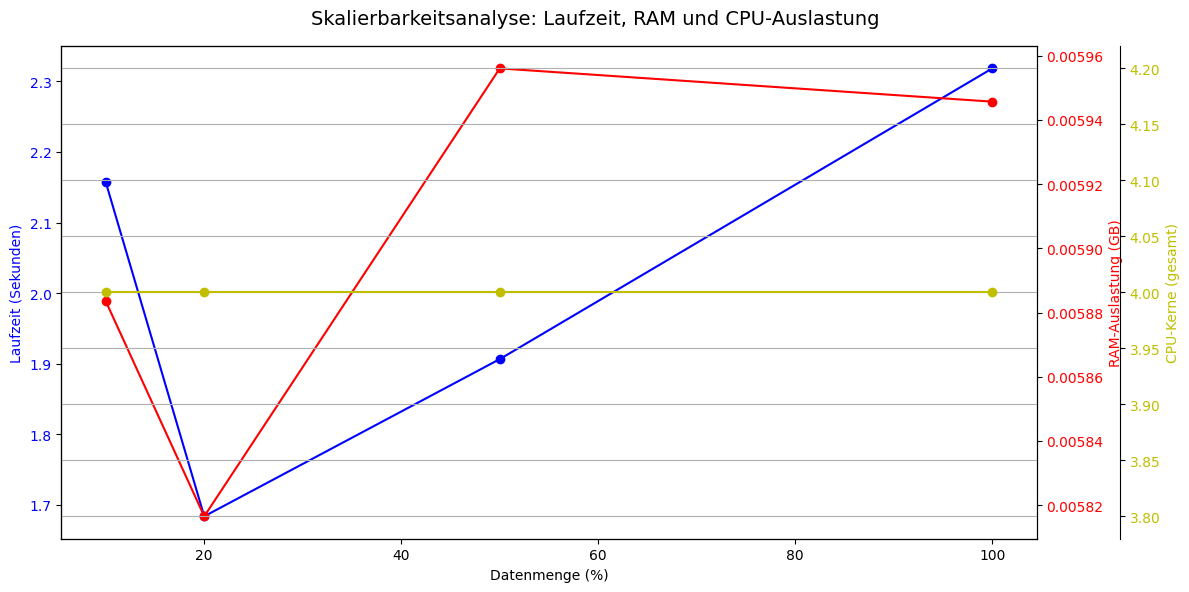

In [25]:
import time
import matplotlib.pyplot as plt


# Skalierbarkeit

# Definition der zu verarbeitenden Datenmenge
percentages = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%

# Listen für Plot vorbereiten
x_data = []
y_time = []
memory_data = []
cpu_data = []

for percentage in percentages:
    print(f"\nVerarbeite {percentage*100}% der Daten...")

    # Startzeit messen
    start_time = time.time()

    # Funktion aufrufen
    result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=percentage)
    
    # Cluster-Metriken abrufen
    total_memory, total_cpu = get_executor_metrics(master_url)

    # Endzeit messen
    end_time = time.time()

    # Daten für den Plot sammeln
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time - start_time)  # Verarbeitungszeit
    memory_data.append(total_memory / (1024**3))  # Speicher in GB
    cpu_data.append(total_cpu)  # CPU-Kerne

plot_results(x_data, y_time, memory_data, cpu_data)

### 3.5 Analyse - Kombination Flugobjekte und Bewegungsdaten

- Laufzeit:
  - Führt die Funktionen `analyze_flight_movements`, `restructure_flight_movements`, `analyze_aircraft_data`, `combine_rdds` und `analyze_combined_rdd` mit einem sehr kleinen Datenanteil (`0.0001%`) aus.
  - Misst die dafür benötigte Zeit, um eine Basiszeit (`base_time`) zu bestimmen.
  
- Laufzeitmessung:
  - Führt dieselben Funktionen mit `100%` der Daten aus.
  - Misst die gesamte Ausführungszeit und subtrahiert die zuvor ermittelte Basiszeit, um die tatsächliche Verarbeitungszeit zu berechnen.
  
- Datenverteilung:
  - Analysiert die Verteilung der Daten im kombinierten RDD über die verschiedenen Partitionen mithilfe der Funktion `analyze_partition_distribution`.
  
- Ausgabe:
  - Gibt die berechnete Laufzeit für die Verarbeitung der vollständigen Datenmenge sowie die Ergebnisse der Datenverteilungsanalyse aus.


**Laufzeit**
- Durchführung der Funktion mit einer minimalen Teilmenge der Daten, um eine Basismessung der benötigten Zeit zu erhalten.
- Ausgabe der Laufzeit bei der Verarbeitung aller Daten, abzüglich der Basiszeit.

In [26]:
import time

# Basiszeit

# Startzeit messen
start_time = time.time() 

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=0.0001)
vehicle_rdd_rdd = restructure_flight_movements(dataRDD)
result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd, 0.0001) #0.01% der Daten für Basiszeit

# Endzeit messen
end_time = time.time()

#Basiszeit errechnen
base_time = end_time-start_time


# Laufzeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
vehicle_rdd = restructure_flight_movements(dataRDD)    
result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd)

# Endzeit messen
end_time = time.time()

print(f"Die Funktion hat für 100% der Daten {end_time - start_time:.4f} Sekunden benötigt")

Die Funktion hat für 100% der Daten 5.6919 Sekunden benötigt


**Datenverteilung**
- Bestimmung der Gesamtzahl der Datenpunkte im Dataset.
- Untersuchung der Anzahl der Partitionen sowie der Verteilung der Daten über diese Partitionen.

In [27]:
analyze_partition_distribution(combined_analyzed_rdd)


=== Partition Verteilung ===

Worker: DY2G339FMM
├── Anzahl Partitionen: 7
├── Gesamt Records: 464
└── Details:
    ├── Partition 0: 65 Records
    ├── Partition 1: 77 Records
    ├── Partition 2: 54 Records
    ├── Partition 3: 63 Records
    ├── Partition 4: 66 Records
    ├── Partition 5: 76 Records
    ├── Partition 6: 63 Records


**Fehlertoleranz**
- Durchführung einer Analyse in Spark Cluster.
- Optional: Händisches beenden ("killen") einer Worker Node im Cluster.
- Ausgabe eines Protokolls, dass die benötigte Zeit sowie die Ergebnisse der Analyse zeigt.

In [28]:
result_log = simulate_worker_failure(analyze_combined_rdd, combined_rdd, worker_pids)


Erste Analyse startet...
Erste Analyse: 1.4 Sekunden

Worker PIDs: [19665, 19709]

Zweite Analyse startet...
Zweite Analyse: 1.4 Sekunden
Analyse erfolgreich durchgeführt!


**Skalierbarkeit**
- Definiert verschiedene Datenmengen (10%, 20%, 50%, 100%) zur Analyse der Verarbeitungseffizienz.
- Misst die Ausführungszeit der Funktion `analyze_flight_movements` für jede Datenmenge und subtrahiert die Basiszeit.
- Speicherauslastung: Erfasst die RAM-Auslastung im Cluster unmittelbar der Verarbeitung.
- CPU-Auslastung: Misst die CPU-Auslastung im Cluster unmittelbar nach der Verarbeitung.
  
- Datenvisualisierung: Erstellt ein Diagramm mit Matplotlib, um die gesammelten Leistungsmetriken in Abhängigkeit von der verarbeiteten Datenmenge darzustellen:
  1. Verarbeitungszeit vs. Datenmenge (%)
  2. RAM-Auslastung vs. Datenmenge (%)
  3. CPU-Auslastung vs. Datenmenge (%)

In [29]:
import time

# Definition der zu verarbeitenden Datenmenge
percentages = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%

# Listen für Plot vorbereiten
x_data = []
y_time = []
memory_data = []
cpu_data = []

for percentage in percentages:
    print(f"\nVerarbeite {percentage*100}% der Daten...")
    
    # Startzeit messen
    start_time = time.time()

    # Funktionen aufrufen
    result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=percentage)
    vehicle_rdd_rdd = restructure_flight_movements(dataRDD)
    result, aircraft_raw_rdd, aircraftRDD = analyze_aircraft_data(aircraft_data_path)
    combined_rdd = combine_rdds(vehicle_rdd, aircraft_raw_rdd)
    combined_analyzed_rdd, result = analyze_combined_rdd(combined_rdd, percentage)
    
    # Cluster-Metriken abrufen
    total_memory, total_cpu = get_executor_metrics(master_url)

    # Endzeit messen
    end_time = time.time()

    # Daten für den Plot sammeln
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time - start_time)  # Verarbeitungszeit
    memory_data.append(total_memory / (1024**3))  # Speicher in GB
    cpu_data.append(total_cpu)  # CPU-Kerne
    
    # Daten für den Plot sammeln
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time - start_time)  # Verarbeitungszeit
    memory_data.append(total_memory / (1024**3))  # Speicher in GB
    cpu_data.append(total_cpu)  # CPU-Kerne
  
# Ergebnisse plotten
plot_results(x_data, y_time, memory_data, cpu_data)


Verarbeite 10.0% der Daten...


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/Users/I750252/myenv/lib/python3.13/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/I750252/myenv/lib/python3.13/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

### 3.6 Analyse - Heatmap der Bewegungsdaten

- Laufzeit:
  - Führt die Funktionen `analyze_flight_movements`, `process_and_reduce` und `create_heatmap` mit einem sehr kleinen Datenanteil (`0.0001%`) aus.
  - Misst die dafür benötigte Zeit (`base_time`), um eine Basiszeit zu bestimmen.
  - Führt dieselben Funktionen mit `100%` der Daten aus.
  - Misst die gesamte Ausführungszeit und subtrahiert die zuvor ermittelte Basiszeit, um die tatsächliche Verarbeitungszeit zu berechnen.
  
- Datenverteilung: Analysiert die Verteilung der Daten im reduzierten RDD über die verschiedenen Partitionen mithilfe der Funktion `analyze_partition_distribution`.
  
- Ausgabe:
  - Gibt die berechnete Laufzeit für die Verarbeitung der vollständigen Datenmenge sowie die Ergebnisse der Datenverteilungsanalyse aus.
  - Erstellt und zeigt eine Heatmap basierend auf den reduzierten Koordinaten.

**Laufzeit**
- Durchführung der Funktion mit einer minimalen Teilmenge der Daten, um eine Basismessung der benötigten Zeit zu erhalten.
- Ausgabe der Laufzeit bei der Verarbeitung aller Daten, abzüglich der Basiszeit.

In [32]:
import time

# Basiszeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=0.0001)
reduced_rdd, result = process_and_reduce(dataRDD)
map = create_heatmap(reduced_rdd)

# Endzeit messen
end_time = time.time()

# Basiszeit errechenen
base_time = end_time-start_time


# Laufzeit

# Startzeit messen
start_time = time.time()

# Funktionen aufrufen
result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path)
reduced_rdd, result = process_and_reduce(dataRDD)
print(result)
map = create_heatmap(reduced_rdd)

# Endzeit messen
end_time = time.time()

print(f"Die Funktion hat für 100% der Daten {(end_time - start_time - base_time):.4f} Sekunden benötigt")

Anzahl der Daten vor der Reduktion: 958473
Anzahl Koordinaten nach der Reduktion: 18748

Die Funktion hat für 100% der Daten 1.3536 Sekunden benötigt


**Datenverteilung**
- Bestimmung der Gesamtzahl der Datenpunkte im Dataset.
- Untersuchung der Anzahl der Partitionen sowie der Verteilung der Daten über diese Partitionen.

In [ ]:
analyze_partition_distribution(reduced_rdd)


=== Partition Verteilung ===

Worker: DY2G339FMM
├── Anzahl Partitionen: 3
├── Gesamt Records: 18748
└── Details:
    ├── Partition 0: 6237 Records
    ├── Partition 1: 6163 Records
    ├── Partition 2: 6348 Records


**Fehlertoleranz**
- Durchführung einer Analyse in Spark Cluster.
- Optional: Händisches beenden ("killen") einer Worker Node im Cluster.
- Ausgabe eines Protokolls, dass die benötigte Zeit sowie die Ergebnisse der Analyse zeigt.

In [39]:
result_log = simulate_worker_failure(process_and_reduce, dataRDD, worker_pids) # Visualisierung findet bei Client statt, somit nicht relevant für Cluster


Erste Analyse startet...


ERROR:root:KeyboardInterrupt while sending command.                 (0 + 0) / 3]
Traceback (most recent call last):
  File "/Users/I750252/myenv/lib/python3.13/site-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/Users/I750252/myenv/lib/python3.13/site-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
                          ~~~~~~~~~~~~~~~~~~~~^^
  File "/opt/homebrew/Cellar/python@3.13/3.13.1/Frameworks/Python.framework/Versions/3.13/lib/python3.13/socket.py", line 719, in readinto
    return self._sock.recv_into(b)
           ~~~~~~~~~~~~~~~~~~~~^^^
KeyboardInterrupt


KeyboardInterrupt: 

**Skalierbarkeit**
- Definiert verschiedene Datenmengen (10%, 20%, 50%, 100%) zur Analyse der Verarbeitungseffizienz.
- Misst die Ausführungszeit der Funktion `analyze_flight_movements` für jede Datenmenge und subtrahiert die Basiszeit.
- Speicherauslastung: Erfasst die RAM-Auslastung im Cluster unmittelbar der Verarbeitung.
- CPU-Auslastung: Misst die CPU-Auslastung im Cluster unmittelbar nach der Verarbeitung.
  
- Datenvisualisierung: Erstellt ein Diagramm mit Matplotlib, um die gesammelten Leistungsmetriken in Abhängigkeit von der verarbeiteten Datenmenge darzustellen:
  1. Verarbeitungszeit vs. Datenmenge (%)
  2. RAM-Auslastung vs. Datenmenge (%)
  3. CPU-Auslastung vs. Datenmenge (%)


Verarbeite 10.0% der Daten...

Verarbeite 20.0% der Daten...

Verarbeite 50.0% der Daten...

Verarbeite 100.0% der Daten...


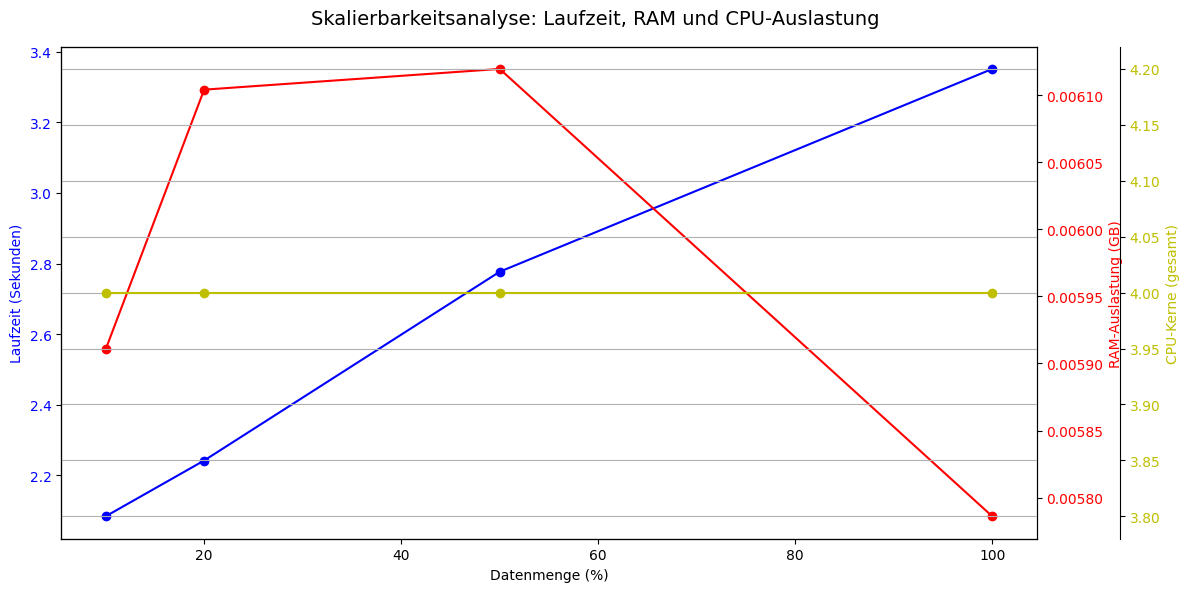

In [ ]:
import time

# Skalierbarkeit
percentages = [0.1, 0.2, 0.5, 1.0]  # 10%, 20%, 50%, 100%

# Listen für Plot vorbereiten
x_data = []
y_time = []
memory_data = []
cpu_data = []

for percentage in percentages:
    print(f"\nVerarbeite {percentage*100}% der Daten...")

    # Startzeit messen
    start_time = time.time()

    # Funktionen aufrufen
    result_text, map_result, dataRDD = analyze_flight_movements(flight_data_path, percentage=percentage)
    reduced_rdd, result = process_and_reduce(dataRDD)
    map = create_heatmap(reduced_rdd)

    # Cluster-Metriken abrufen
    total_memory, total_cpu = get_executor_metrics(master_url)

    # Endzeit messen
    end_time = time.time()

    # Daten für den Plot sammeln
    x_data.append(percentage * 100)  # Prozentuale Datenmenge
    y_time.append(end_time - start_time)  # Verarbeitungszeit
    memory_data.append(total_memory / (1024**3))  # Speicher in GB
    cpu_data.append(total_cpu)  # CPU-Kerne

# Ergebnisse plotten
plot_results(x_data, y_time, memory_data, cpu_data)

================================================================================================================================================================================

### 4 Experimente

**Analyse 6: Fehlertoleranz und Laufzeiten bei Worker Node abschießen - Beispielhaft für die Funktion analyze_flight_movements**

**Voraussetzungen:**
1. Spark installiert
2. Python installiert
3. Java Version 11 installiert 
    - über brew: brew install openjdk@11
4. Konfigurieren von spark config 
    - Pfad standardmäßig unter /usr/local/spark-<version>/conf
    - ansonsten: find / -name "spark-defaults.conf" 2>/dev/null
    - spark-env.sh.template kopieren und umbennen in spark-env.sh und folgende Parameter hinzufügen:
        <br>SPARK_WORKER_INSTANCES=2
        <br>SPARK_WORKER_CORES=4
        <br>SPARK_WORKER_MEMORY=4g
        <br>SPARK_MASTER_HOST=127.0.0.1
    - (workers.template kopieren und umbennen in workers)
5. Input-Dateien für Spark zugänglich machen (siehe Pfad im Coding)

**Vorgehen:**
1. Starten von Master und Worker Nodes unter localhost 
    - Spark Pfad öffnen: cd /usr/local/spark-3.5.3-bin-hadoop3
    - Master: ./sbin/start-master.sh
        -  Web-UI: http://localhost:8080
    - Worker: ./sbin/start-worker.sh spark://localhost:7077
2. Coding für analyze_flight_movements ausführen zur Definition der Funktion
2. Starten des Codings für die Analyse der Fehlertoleranz. Dieses führt dann zunächst die Funktion regulär aus und misst die dafür benötigte Laufzeit.
3. Coding fordert Enter-Eingabe auf. An diesem Punkt sind beliebig viele Worker Nodes zu killen, dann die Enter-Eingabe tätigen. 
    - Worker killen: kill -9 PID
    - PID: kann unter dem Log Ordner in der jeweiligen Log-Datei für den Worker gefunden werden unter dem Abschnitt "Started daemon with process name: (PID)
    - Gekillte Worker sollten unter der Web-UI zu sehen sein
4. Enter-Eingabe führt zur erneuten Ausführung der Funktion mit abgeschossenen Nodes.
5. Worker/Master beenden:
    - ./sbin/stop-all.sh

**Ergänzend: **
Zum Testen, wie die Ausführung des Codes währen der Laufzeit auf das Abschiessen von Worker Nodes reagiert, können diese auch während der ersten oder zweiten Ausführung gekillt werden.


In [36]:
from pyspark.sql import SparkSession
import time
import requests

# SparkSession erstellen
spark = SparkSession.builder \
    .appName("ClusterResourceMonitoring") \
    .getOrCreate()

sc = spark.sparkContext

# Funktion zur Überwachung von Cluster-Ressourcen
def monitor_cluster_resources(interval=5, duration=60):
    """
    Überwacht die CPU- und RAM-Auslastung im Cluster.
    interval: Intervall in Sekunden, in dem Metriken gesammelt werden.
    duration: Gesamtdauer der Überwachung in Sekunden.
    """
    end_time = time.time() + duration
    metrics = []

    while time.time() < end_time:
        # Spark-Metriken auslesen
        executors = sc._jsc.sc().statusTracker().getExecutorInfos()
        for executor in executors:
            metrics.append({
                "executor_id": executor.executorId(),
                "host": executor.host(),
                "total_cores": executor.totalCores(),
                "max_memory": executor.maxMemory() / (1024 * 1024),  # In MB
                "used_memory": executor.memoryUsed() / (1024 * 1024),  # In MB
            })
        time.sleep(interval)

    # Ergebnisse ausgeben
    for metric in metrics:
        print(metric)

# Beispielaufruf
monitor_cluster_resources(interval=5, duration=30)


25/01/22 21:41:19 WARN SparkSession: Using an existing Spark session; only runtime SQL configurations will take effect.


Py4JError: An error occurred while calling o3999.executorId. Trace:
py4j.Py4JException: Method executorId([]) does not exist
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:321)
	at py4j.reflection.ReflectionEngine.getMethod(ReflectionEngine.java:329)
	at py4j.Gateway.invoke(Gateway.java:274)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.ClientServerConnection.waitForCommands(ClientServerConnection.java:182)
	at py4j.ClientServerConnection.run(ClientServerConnection.java:106)
	at java.base/java.lang.Thread.run(Thread.java:1583)



==== **Vorverarbeitung der Datenquelle** ===
- Nur notwendig für Vorverarbeitung von Bewegungsdaten zur Umwandlung in notwendiges Datenformat
- Laden: Liest eine Pipe-getrennte CSV-Datei (`data.csv`).
- Spalten auswählen und umbenennen**: Wählt die Spalten `icao24`, `time`, `latitude`, `longitude`, `onground` aus und benennt sie um.
- Daten konvertieren**:
    - Zeit: Wandelt Unix-Timestamps in lesbares Format um.
    - Status: Konvertiert `onground` von `true`/`false` zu `1`/`0`.
- Speichern: Speichert die bereinigten Daten in `processed_data.csv`.

In [ ]:
#import pandas as pd
#from datetime import datetime

# CSV-Datei laden, wobei das Pipe-Zeichen als Trennzeichen angegeben wird
#csv_file_path = "data.csv"  # Ersetze dies mit dem Pfad zu deiner CSV-Datei
#df = pd.read_csv(csv_file_path, sep='|')  # Verwende '|' als Trennzeichen

# Angenommene Spaltennummern: time = 0, icao24 = 1, lat = 2, lon = 3, onground = 4
#column_indices = [1, 0, 2, 3, 4]  # Die Spalten in der gewünschten Reihenfolge auswählen
#df_selected = df.iloc[:, column_indices]

# Umbenennen der Spalten
#df_selected.columns = ['time', 'icao24', 'latitude', 'longitude', 'onground']

# Funktion zur Konvertierung des Unix-Timestamps
#def convert_timestamp(unix_timestamp):
#    try:
#        return datetime.utcfromtimestamp(int(unix_timestamp)).strftime('%Y/%m/%d %H:%M:%S')
#    except ValueError:
#        return None

# Konvertiere die 'time'-Spalte
#df_selected['time'] = df_selected['time'].apply(convert_timestamp)

# Umwandlung der 'onground'-Spalte, 'true' -> 1 und 'false' -> 0
#df_selected['onground'] = df_selected['onground'].apply(lambda x: 1 if str(x).strip().lower() == 'true' else 0)

# Sicherstellen, dass 'time' an erster Stelle bleibt
#df_selected = df_selected[['time', 'icao24', 'latitude', 'longitude', 'onground']]

# Speichere das Ergebnis als neue CSV-Datei
#df_selected.to_csv("processed_data.csv", index=False)

**POC zu Parquet**

- Liest ein Parquet-File (`bigDataSet_v2.parquet`) in einen Spark DataFrame.  
- Zeigt die ersten 3 Zeilen (`df.show(3)`) und druckt Schema und Spaltennamen.  
- Wandelt den DataFrame in ein RDD um (`df.rdd`) und gibt die ersten 3 Einträge aus (`rdd.take(3)`).

In [ ]:
# Datenverteilung im CLuster
def analyze_partition_distribution(rdd):
    """
    Analysiert die Verteilung der Daten in einem RDD über die Partitionen.

    Diese Funktion berechnet die Größe jeder Partition in einem RDD und gibt eine Übersicht über 
    die Anzahl der Datensätze in jeder Partition sowie die Gesamtzahl der Datensätze und Partitionen zurück.

    :param rdd: Das RDD, das analysiert werden soll.

    :return: Ein Tuple bestehend aus:
             - Der Anzahl der Datensätze im RDD
             - Der Anzahl der Partitionen im RDD
             - Eine formatierte String-Ausgabe der Verteilung der Daten auf die Partitionen
    """
    
    # Funktion, um die Größe jeder Partition zu berechnen
    def partition_sizes(index, iterator):
        yield index, sum(1 for _ in iterator)

   # Daten je Partition sammeln
    partition_info = rdd.mapPartitionsWithIndex(partition_sizes).collect()

    # Anzahl der Partitionen ermitteln
    num_partitions = rdd.getNumPartitions()

    #Ergebnisse formatieren
    number_data = f"Anzahl der Datensätze: {rdd.count()}\n"
    number_partition = f"Anzahl der Partitionen: {num_partitions}\n"
    result = "Datenverteilung auf Partitionen:\n"

    # Ausgabe der Verteilung pro Partition
    for partition, size in partition_info:
        result += f"Partition {partition}: {size} Datensätze\n"

    return number_data, number_partition, result

In [ ]:

def get_system_info():
    """
    Ermittelt und gibt eine Übersicht über die Systeminformationen zurück.

    Diese Funktion sammelt und gibt verschiedene Systeminformationen wie CPU- und RAM-Daten zurück. 
    Dazu gehören die Anzahl der physischen und logischen CPUs, die CPU-Frequenz, die CPU-Auslastung sowie 
    Details zum RAM, wie der verfügbare, genutzte und gesamte Speicher sowie die RAM-Auslastung.

    :return: Ein String, der die Systeminformationen, einschließlich der CPU- und RAM-Daten, formatiert darstellt.
    """

    # CPU-Informationen
    cpu_count = psutil.cpu_count(logical=False)  # Anzahl physikalischer CPU-Kerne
    logical_cpu_count = psutil.cpu_count(logical=True)  # Anzahl logischer CPUs (mit Hyper-Threading)
    cpu_freq = psutil.cpu_freq()  # CPU Frequenz
    cpu_percent = psutil.cpu_percent(interval=1)  # CPU-Auslastung in Prozent

    # RAM-Informationen
    virtual_memory = psutil.virtual_memory()  # Virtueller Speicher (RAM)
    total_memory = virtual_memory.total  # Gesamtgröße des RAM
    available_memory = virtual_memory.available  # Verfügbarer RAM
    used_memory = virtual_memory.used  # Genutzter RAM
    memory_percent = virtual_memory.percent  # Prozentsatz des verwendeten RAM


    # Ausgabe der gesammelten Informationen
    result = "=" * 50
    result += "System Informationsübersicht"
    result += "=" * 50\

    result += "\nCPU Infos:\n"
    result += f"  - Anzahl der physischen CPU-Kerne: {cpu_count}\n"
    result += f"  - Anzahl der logischen CPU-Kerne (inkl. Hyper-Threading): {logical_cpu_count}\n"
    result += f"  - Aktuelle CPU Frequenz: {cpu_freq.current} MHz\n"
    result += f"  - Aktuelle CPU Auslastung: {cpu_percent}%\n"

    result += "\nRAM Infos:\n"
    result += f"  - Gesamter RAM: {total_memory / (1024 ** 3):.2f} GB\n"
    result += f"  - Verfügbarer RAM: {available_memory / (1024 ** 3):.2f} GB\n"
    result += f"  - Genutzter RAM: {used_memory / (1024 ** 3):.2f} GB\n"
    result += f"  - RAM Auslastung: {memory_percent}%"

    return result

In [ ]:
print(get_system_info())


Verarbeite 10.0% der Daten...

Verarbeite 20.0% der Daten...

Verarbeite 50.0% der Daten...

Verarbeite 100.0% der Daten...


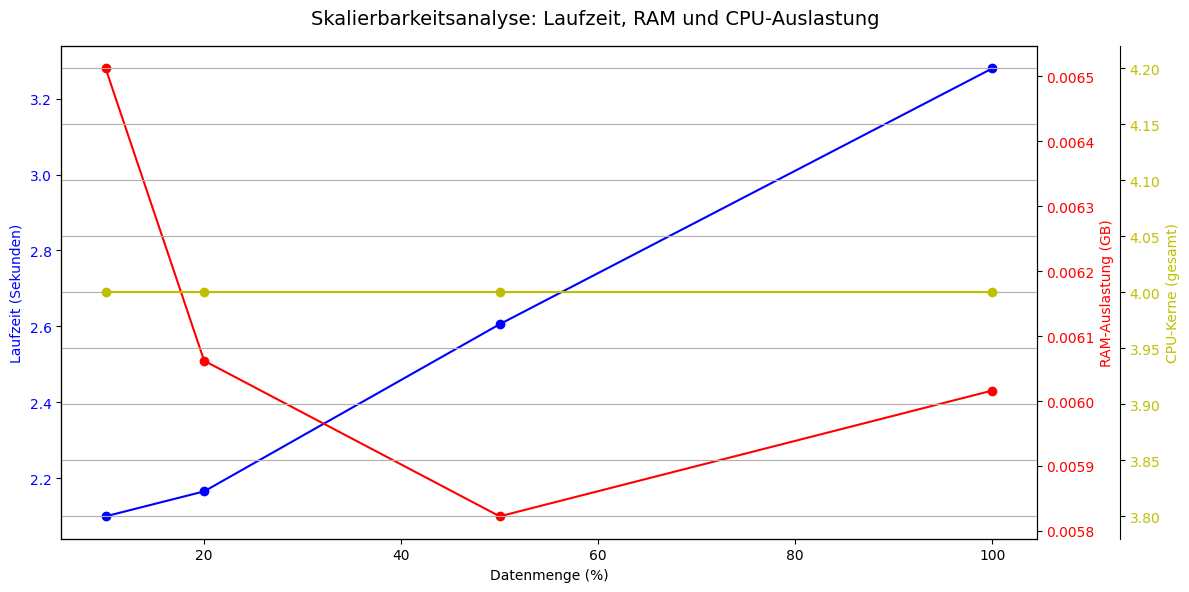